## KP Slc4a11-MCD mTmG traced mice
8/7/2024 - Data generated from 17 week KP Slc4a11-MCD mTmG mice treated with Cisplatin vs MRTX for 3 weeks; data submitted by CHP/EB on 7/15/2024, analyzed by JC 8/7/2024

Note BG1006 should be BG1005

8/26/2025 - Reran with latest libraries to ensure consistency

Analyze global run with GEM-X and now cellranger v8.0.1 data with introns and create h5_ad files for further analysis

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc

import math
import matplotlib

from pathlib import Path
import anndata

In [2]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')
np.random.seed(1573)   #fix so we can reproduce later

In [3]:
Path("./figures").mkdir(parents=True, exist_ok=True) # generate figures here
Path("./write").mkdir(parents=True, exist_ok=True) # write h5ad here

In [4]:
results_file = 'write/IGO16235-mTmG-3week-treated.h5ad'  # the file that will store the analysis results

In [5]:
adata = sc.read_10x_h5('GSE277777_IGO16235-filtered_feature_bc_matrix_wintron.h5', gex_only=False)

reading GSE277777_IGO16235-filtered_feature_bc_matrix_wintron.h5
 (0:00:03)


/Users/chanj2/opt/miniconda3/envs/part1-cellrank/lib/python3.11/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [6]:
adata.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`

In [7]:
samples = list(adata[:,adata.var['feature_types']=='Antibody Capture'].var.index)

In [8]:
#Fix incorrect mTagBFP2 naming
adata.var_names = adata.var_names.str.replace('mTagBFP2', 'tagBFP')

In [9]:
# Now filter out barcodes
hashadata = adata[:,samples]
adata = adata[:,[y for y in adata.var_names if y not in samples]]

In [10]:
hashadata.var

gene_ids     feature_types genome                    pattern  \
BH1064_B0301   BH1064  Antibody Capture         5PNNNNNNNNNN(BC)NNNNNNNNN   
BI1614_B0302   BI1614  Antibody Capture         5PNNNNNNNNNN(BC)NNNNNNNNN   
BI1771_B0303   BI1771  Antibody Capture         5PNNNNNNNNNN(BC)NNNNNNNNN   
BI1772_B0304   BI1772  Antibody Capture         5PNNNNNNNNNN(BC)NNNNNNNNN   
BJ1072_B0305   BJ1072  Antibody Capture         5PNNNNNNNNNN(BC)NNNNNNNNN   
BI1938_B0306   BI1938  Antibody Capture         5PNNNNNNNNNN(BC)NNNNNNNNN   
BJ1074_B0307   BJ1074  Antibody Capture         5PNNNNNNNNNN(BC)NNNNNNNNN   
BG1006_B0308   BG1006  Antibody Capture         5PNNNNNNNNNN(BC)NNNNNNNNN   

             read         sequence  
BH1064_B0301   R2  ACCCACCAGTAAGAC  
BI1614_B0302   R2  GGTCGAGAGCATTCA  
BI1771_B0303   R2  CTTGCCGCATGTCAT  
BI1772_B0304   R2  AAAGCATTCTTCACG  
BJ1072_B0305   R2  CTTTGTCTTTGTGAG  
BI1938_B0306   R2  TATGCTGCCACGGTA  
BJ1074_B0307   R2  GAGTCTGCCAGTATC  
BG1006_B0308   R2  TATAGAACGCCAGGC

## Preprocessing

/Users/chanj2/opt/miniconda3/envs/part1-cellrank/lib/python3.11/site-packages/scanpy/preprocessing/_normalization.py:269: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


normalizing counts per cell
    finished (0:00:00)


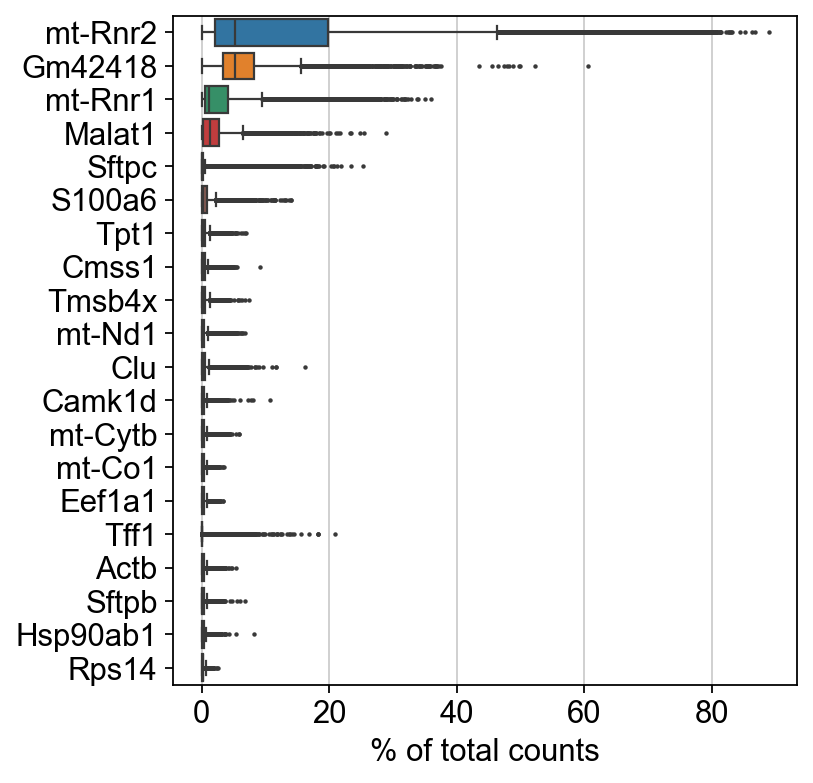

In [11]:
sc.pl.highest_expr_genes(adata, n_top=20, )

Basic filtering:

In [12]:
sc.pp.filter_cells(adata, min_counts=1500)
sc.pp.filter_cells(adata, min_genes=300)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 1804 cells that have less than 1500 counts
filtered out 1476 cells that have less than 300 genes expressed
filtered out 26212 genes that are detected in less than 3 cells


In [13]:
adata.var['mt'] = adata.var_names.str.startswith('mt-') # annotate the group of mitochondrial genes as 'MT'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

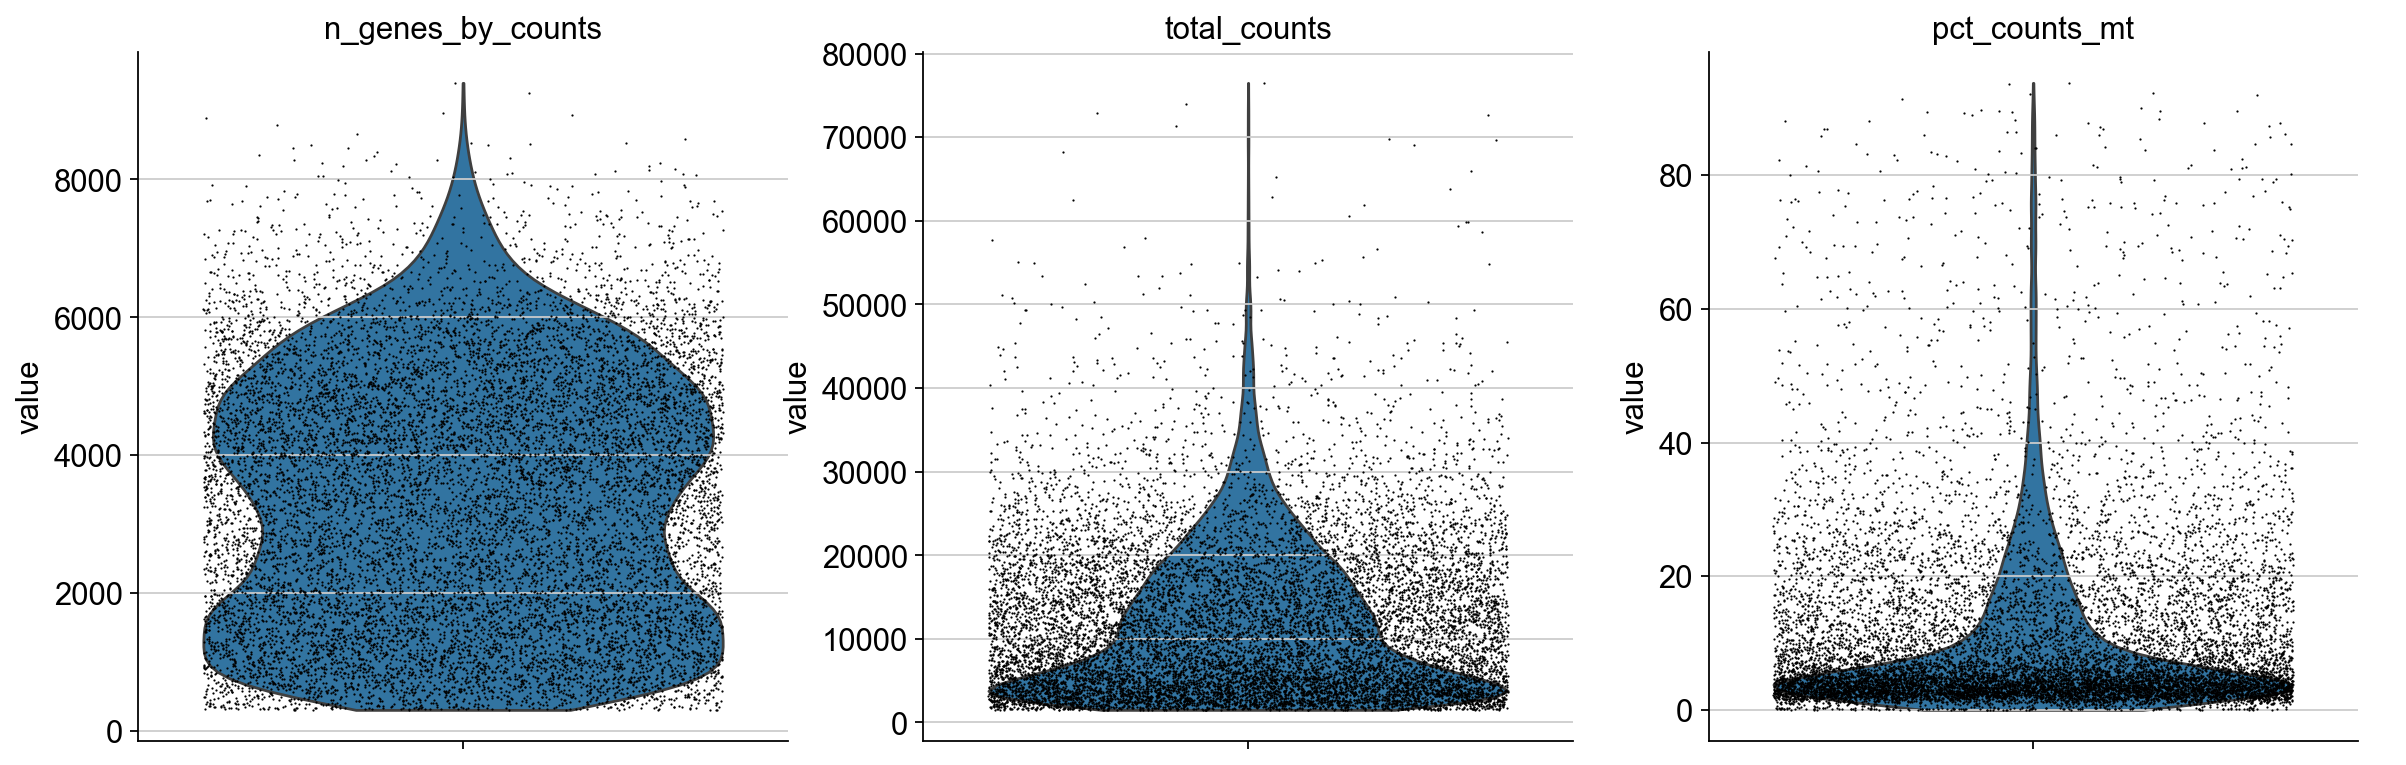

In [14]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True, rotation=90)

(array([   8.,   25.,   46.,  109.,  220.,  415., 1956., 6748., 3304.,
         145.]),
 array([0.63184547, 0.6640264 , 0.69620733, 0.72838826, 0.7605692 ,
        0.79275013, 0.82493106, 0.857112  , 0.88929293, 0.92147386,
        0.95365479]),
 <BarContainer object of 10 artists>)

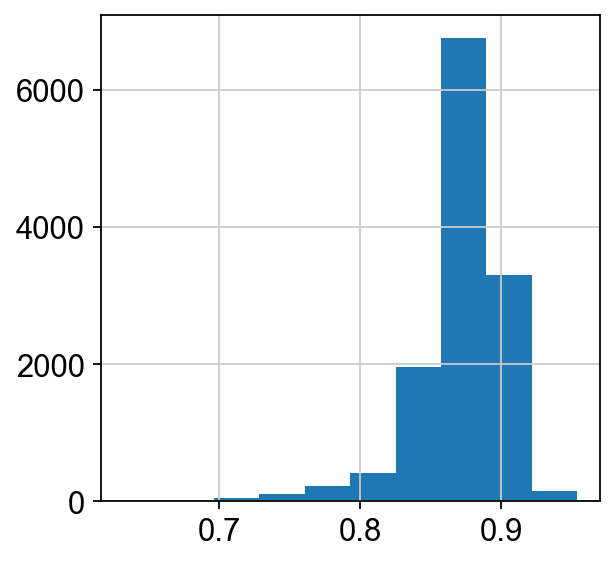

In [15]:
adata.obs["log10GenesPerUMI"] = adata.obs['n_genes_by_counts'].apply(math.log10) / adata.obs['total_counts'].apply(math.log10)
matplotlib.pyplot.hist(adata.obs["log10GenesPerUMI"])

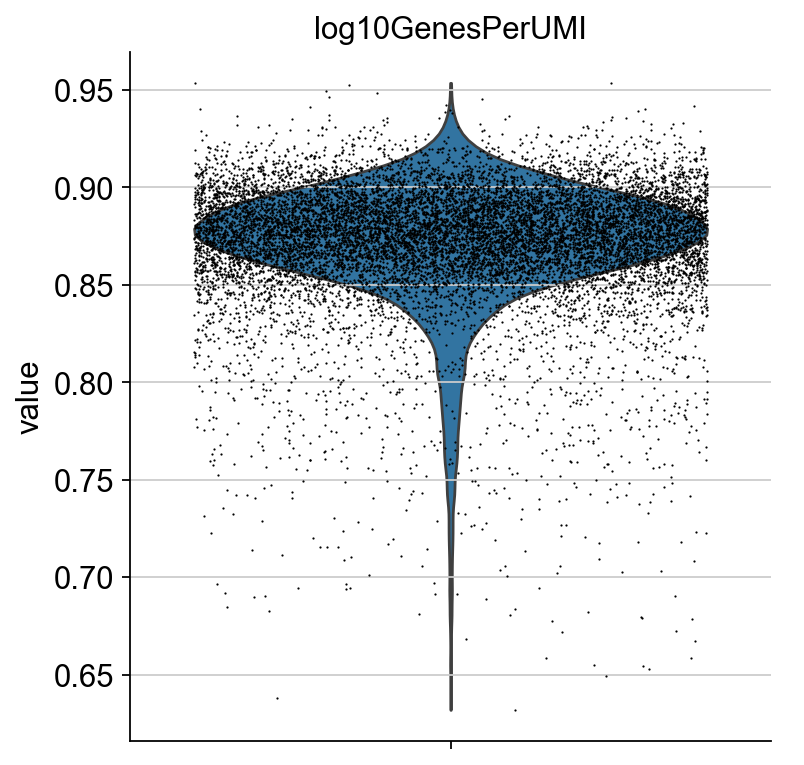

In [16]:
sc.pl.violin(adata, ['log10GenesPerUMI'],
             jitter=0.4, multi_panel=True, rotation=90)

In [17]:
#Filter by Log10GenesPerUMI
adata = adata[adata.obs.log10GenesPerUMI >= 0.8,:]

In [18]:
adata = adata[adata.obs.pct_counts_mt <= 20, :]

## Run Demultiplexing

In [19]:
hashadata = hashadata[hashadata.obs.index.isin(adata.obs.index), :]

In [20]:
hashadata.var_names

Index(['BH1064_B0301', 'BI1614_B0302', 'BI1771_B0303', 'BI1772_B0304',
       'BJ1072_B0305', 'BI1938_B0306', 'BJ1074_B0307', 'BG1006_B0308'],
      dtype='object')

In [21]:
hashCounts = pd.DataFrame(hashadata.X.todense(), columns=hashadata.var_names, index=adata.obs.index)

In [22]:
hashDisc = hashCounts.describe([.1,.2,.3,.4,.5,.6,.7,.8,.9,0.99])
#hashDisc

In [23]:
hashIDs = hashCounts.copy()
hashID = hashadata.var_names
for hashName in hashadata.var_names:
    print(hashName)
    print(hashDisc.loc["90%",hashName])
    hashIDs.loc[:,hashName] = hashCounts.loc[:,hashName] > hashDisc.loc["90%",hashName]
#hashIDs

BH1064_B0301
120.5
BI1614_B0302
842.5
BI1771_B0303
295.0
BI1772_B0304
10.0
BJ1072_B0305
2.0
BI1938_B0306
1.0
BJ1074_B0307
6.0
BG1006_B0308
179.0


/var/folders/xc/wjwqs2j55dqgp2ghrn6nmlj1nlk7kz/T/ipykernel_38020/4170078627.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[False False False ... False  True False]' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  hashIDs.loc[:,hashName] = hashCounts.loc[:,hashName] > hashDisc.loc["90%",hashName]
/var/folders/xc/wjwqs2j55dqgp2ghrn6nmlj1nlk7kz/T/ipykernel_38020/4170078627.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[False False False ...  True False False]' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  hashIDs.loc[:,hashName] = hashCounts.loc[:,hashName] > hashDisc.loc["90%",hashName]
/var/folders/xc/wjwqs2j55dqgp2ghrn6nmlj1nlk7kz/T/ipykernel_38020/4170078627.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise 

In [24]:
from matplotlib import pyplot as plt

In [25]:
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams["font.family"] = "Arial"
plt.rcParams['figure.figsize'] = (3,4)

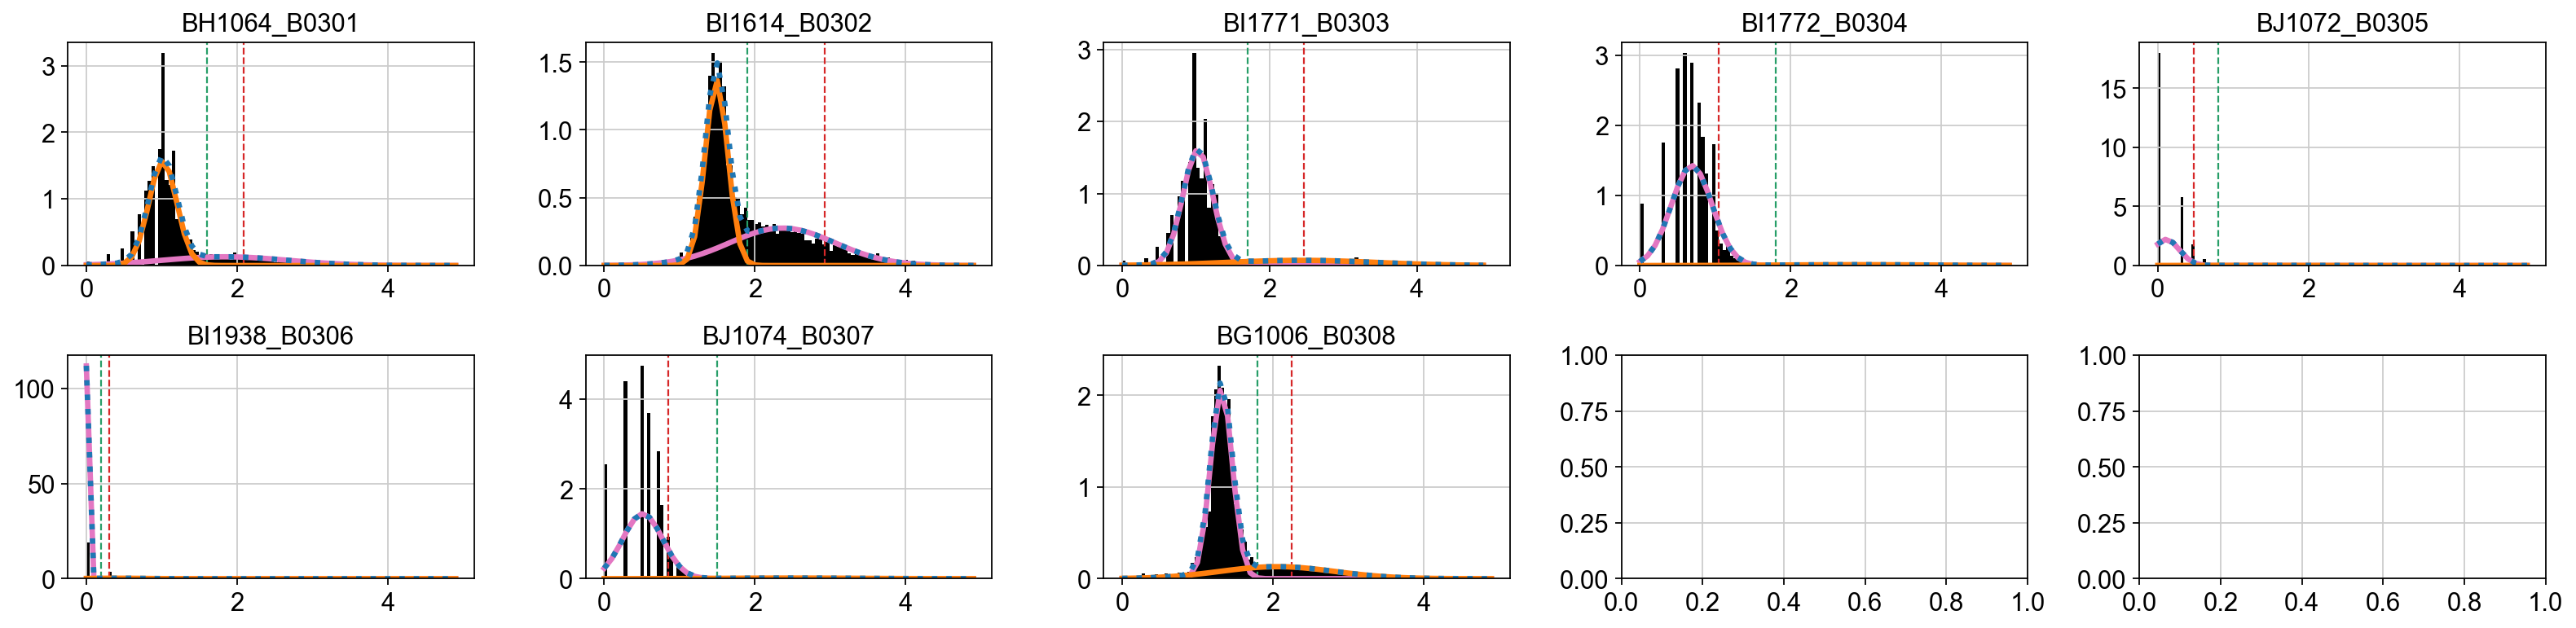

In [26]:
from sklearn.mixture import BayesianGaussianMixture
from scipy.stats import norm
fig, axs = plt.subplots(2,5, figsize =(20, 5))
dfHashBoundry = pd.DataFrame(np.zeros(len(hashadata.var_names)),hashadata.var_names, columns=["boundry"])
gmm = BayesianGaussianMixture(n_components=2, random_state=250,init_params='k-means++')
binEx = np.arange(0,5,5/100).reshape(-1,1)

for i, hashName in enumerate(hashadata.var_names):
    hashCount = np.array(np.log10(hashCounts[hashName]+1)).reshape(-1, 1)
    fitGMM = gmm.fit(hashCount)
    mean = fitGMM.means_  
    covs  = fitGMM.covariances_
    weights = fitGMM.weights_
  
    fitGmmBound = fitGMM.predict(binEx)

    x_axis = np.arange(0, 5, 0.1)
    y_axis0 = norm.pdf(x_axis, float(mean[0][0]), np.sqrt(float(covs[0][0][0])))*weights[0] # 1st gaussian
    y_axis1 = norm.pdf(x_axis, float(mean[1][0]), np.sqrt(float(covs[1][0][0])))*weights[1] # 2nd gaussian

    hashBoundry = False #binEx[np.where(fitGmmBound == 1)[0][0]][0]    
    if mean[0][0] < mean[1][0]:
        hashBoundry = x_axis[np.where(y_axis1 < y_axis0)[0][-1]+2]
    else:
        hashBoundry = x_axis[np.where(y_axis0 < y_axis1)[0][-1]+2]
    
    naiveBoundry = np.log10(int(hashDisc.loc["90%",hashName])+1)
    
    dfHashBoundry.loc[hashName] = hashBoundry
    
    # Plot 2
    axs[i//5,i%5].set_title(hashName)
    axs[i//5,i%5].axvline(naiveBoundry, c='C3', linestyle='dashed', linewidth=1) #red
    axs[i//5,i%5].axvline(hashBoundry, c='C2', linestyle='dashed', linewidth=1)  #green
    axs[i//5,i%5].hist(hashCount, density=True, color='black', bins=100)        
    axs[i//5,i%5].plot(x_axis, y_axis0, lw=3, c='C6')                            #pink
    axs[i//5,i%5].plot(x_axis, y_axis1, lw=3, c='C1')                            #orange
    axs[i//5,i%5].plot(x_axis, y_axis0+y_axis1, lw=3, c='C0', ls=':')            #dotted blue
    
plt.tight_layout(pad=1.0)
#plt.rcParams["figure.figsize"] = (20,5)
plt.show()

In [27]:
hashIDs = hashCounts.copy()
hashID = hashadata.var_names
for hashName in hashadata.var_names:
    print(hashName)
    print(dfHashBoundry.loc[hashName].values[0])
    if hashName == 'BI1938_B0306': #BI1938 poor count, don't believe it.  Set bar higher
        dfHashBoundry.loc['BI1938_B0306'] = 1.0
    hashIDs.loc[:,hashName] = np.log10(hashCounts.loc[:,hashName]+1) > dfHashBoundry.loc[hashName].values[0]
hashIDs

BH1064_B0301
1.6
BI1614_B0302
1.9000000000000001
BI1771_B0303
1.7000000000000002
BI1772_B0304
1.8
BJ1072_B0305
0.8
BI1938_B0306
0.2
BJ1074_B0307
1.5
BG1006_B0308
1.8


/var/folders/xc/wjwqs2j55dqgp2ghrn6nmlj1nlk7kz/T/ipykernel_38020/2938077687.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[False  True False ... False  True False]' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  hashIDs.loc[:,hashName] = np.log10(hashCounts.loc[:,hashName]+1) > dfHashBoundry.loc[hashName].values[0]
/var/folders/xc/wjwqs2j55dqgp2ghrn6nmlj1nlk7kz/T/ipykernel_38020/2938077687.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[False False False ...  True False False]' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  hashIDs.loc[:,hashName] = np.log10(hashCounts.loc[:,hashName]+1) > dfHashBoundry.loc[hashName].values[0]
/var/folders/xc/wjwqs2j55dqgp2ghrn6nmlj1nlk7kz/T/ipykernel_38020/2938077687.py:8: FutureWarning: Setting an item of incomp

BH1064_B0301  BI1614_B0302  BI1771_B0303  BI1772_B0304  \
AAACCAAAGGTTGAGG-1         False         False         False         False   
AAACCAAAGTAGACCC-1          True         False          True         False   
AAACCCGCATCATAGA-1         False         False         False         False   
AAACCCGCATCCCGTG-1         False          True         False         False   
AAACCCTGTAGTCAAG-1          True         False         False         False   
...                          ...           ...           ...           ...   
TGTGTTAGTTCGCATG-1         False         False         False         False   
TGTGTTAGTTCGCTAG-1         False         False         False         False   
TGTGTTAGTTTACCTT-1         False          True         False         False   
TGTGTTGAGATTGAGA-1          True         False         False         False   
TGTGTTGAGTAGACTT-1         False         False          True         False   

                    BJ1072_B0305  BI1938_B0306  BJ1074_B0307  BG1006_B0308  
AAACCAAAGGTTGAGG-1         False         False         False         False  
AAACCAAAGTAGACCC-1         False         False         False         False  
AAACCCGCATCATAGA-1         False         False          True         False  
AAACCCGCATCCCGTG-1         False         False         False         False  
AAACCCTGTAGTCAAG-1         False         False         False         False  
...                          ...           ...           ...           ...  
TGTGTTAGTTCGCATG-1         False         False         False         False  
TGTGTTAGTTCGCTAG-1         False         False         False         False  
TGTGTTAGTTTACCTT-1         False         False         False         False  
TGTGTTGAGATTGAGA-1         False         False         False         False  
TGTGTTGAGTAGACTT-1         False         False         False         False  

[10756 rows x 8 columns]

In [28]:
classification = np.empty(len(adata), dtype="object")
i = 0
for cellBar, hashBool in hashIDs.iterrows():
    numHashes = sum(hashBool)
    if (numHashes == 1):
        classif = hashID[hashBool.values].values[0]
    elif (numHashes > 1):
        classif = "doublet"
    else:
        classif = "negative"
    classification[i] = classif
    i = i + 1

In [29]:
adata.obs["Classification"] = classification
hashadata.obs["Classification"] = classification
adata.obs["Classification"].value_counts()

/var/folders/xc/wjwqs2j55dqgp2ghrn6nmlj1nlk7kz/T/ipykernel_38020/4135005838.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["Classification"] = classification
/var/folders/xc/wjwqs2j55dqgp2ghrn6nmlj1nlk7kz/T/ipykernel_38020/4135005838.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  hashadata.obs["Classification"] = classification


Classification
BI1614_B0302    3278
negative        2193
BH1064_B0301    1364
BG1006_B0308    1329
BI1771_B0303    1145
doublet          961
BJ1074_B0307     192
BI1772_B0304     172
BJ1072_B0305      98
BI1938_B0306      24
Name: count, dtype: int64

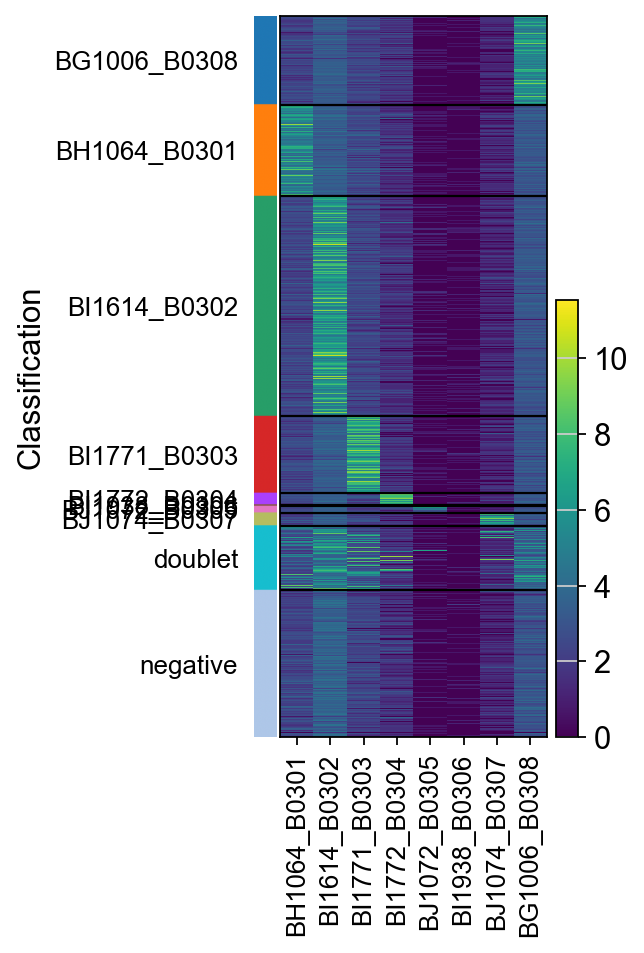

In [30]:
#output visulaization of hashing
sc.pl.heatmap(hashadata, hashadata.var_names, groupby="Classification", log=True)#, save = f"_{figName}_hash.png")

## set transgenes counts

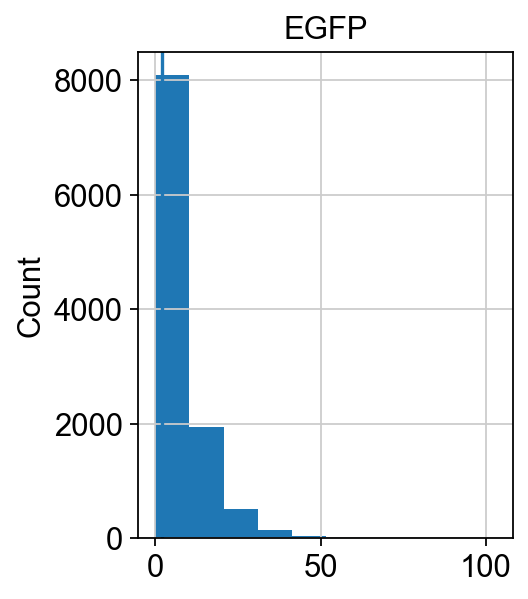

In [31]:
import matplotlib.pyplot as plt
_ = plt.hist(adata.X[:,adata.var.index.isin(['EGFP'])].toarray())
plt.ylabel("Count")
plt.title("EGFP")
plt.axvline(x=2)
plt.show()

In [32]:
adata.obs['EGFP_count'] = adata.X[:,adata.var.index.isin(['EGFP'])].toarray()

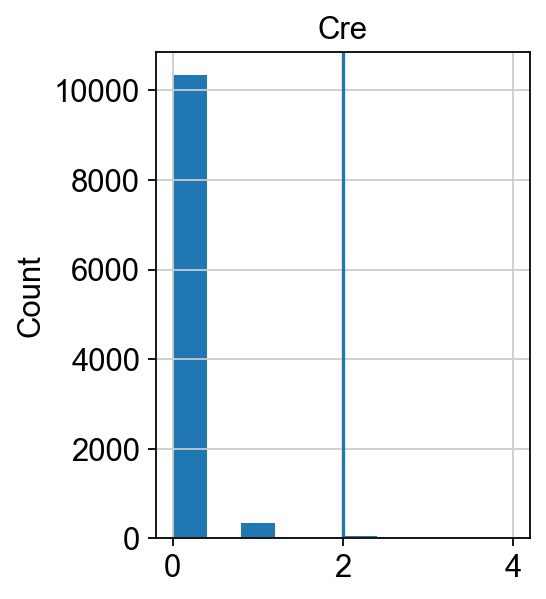

In [33]:
import matplotlib.pyplot as plt
_ = plt.hist(adata.X[:,adata.var.index.isin(['Cre'])].toarray())
plt.ylabel("Count")
plt.title("Cre")
plt.axvline(x=2)
plt.show()

In [34]:
adata.obs['Cre_count'] = adata.X[:,adata.var.index.isin(['Cre'])].toarray()

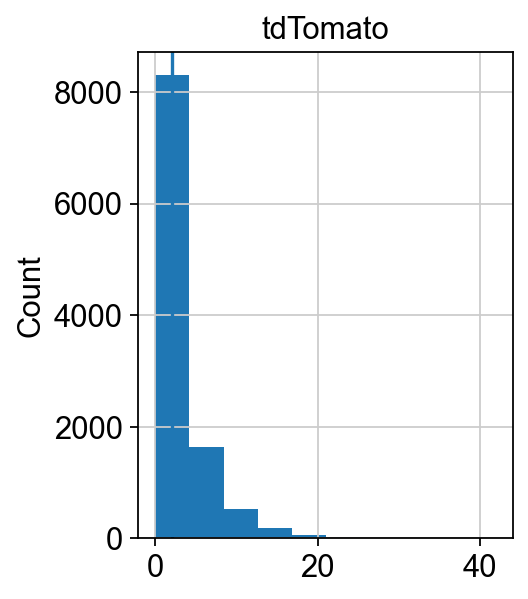

In [35]:
import matplotlib.pyplot as plt
_ = plt.hist(adata.X[:,adata.var.index.isin(['tdTomato'])].toarray())
plt.ylabel("Count")
plt.title("tdTomato")
plt.axvline(x=2)
plt.show()

In [36]:
adata.obs['tdTomato_count'] = adata.X[:,adata.var.index.isin(['tdTomato'])].toarray()

## Filter doublets and negative cells

In [37]:
adata.obs.Classification.value_counts()

Classification
BI1614_B0302    3278
negative        2193
BH1064_B0301    1364
BG1006_B0308    1329
BI1771_B0303    1145
doublet          961
BJ1074_B0307     192
BI1772_B0304     172
BJ1072_B0305      98
BI1938_B0306      24
Name: count, dtype: int64

In [38]:
adata = adata[~adata.obs['Classification'].isin(['doublet','negative']),:]

In [39]:
adata.obs.Classification.value_counts()

Classification
BI1614_B0302    3278
BH1064_B0301    1364
BG1006_B0308    1329
BI1771_B0303    1145
BJ1074_B0307     192
BI1772_B0304     172
BJ1072_B0305      98
BI1938_B0306      24
Name: count, dtype: int64

## Set Groups

In [40]:
samples

['BH1064_B0301',
 'BI1614_B0302',
 'BI1771_B0303',
 'BI1772_B0304',
 'BJ1072_B0305',
 'BI1938_B0306',
 'BJ1074_B0307',
 'BG1006_B0308']

In [41]:
#Set shRNA groups
adata.obs['Group'] = 'Cisplatin'
adata.obs['Group'][adata.obs.Classification.isin(['BH1064_B0301','BI1614_B0302'])] = 'Saline'
adata.obs['Group'][adata.obs.Classification.isin(['BI1938_B0306','BJ1074_B0307'])] = 'MRTX1133'
adata.obs['Group'][adata.obs.Classification.isin(['BG1006_B0308'])] = 'KP'

/var/folders/xc/wjwqs2j55dqgp2ghrn6nmlj1nlk7kz/T/ipykernel_38020/1667983825.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['Group'] = 'Cisplatin'
/var/folders/xc/wjwqs2j55dqgp2ghrn6nmlj1nlk7kz/T/ipykernel_38020/1667983825.py:3: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation:

In [42]:
# Remove carrier KP mouse cells
adata = adata[~adata.obs['Group'].isin(['KP']),:]

In [43]:
adata.obs.Group.value_counts()

Group
Saline       4642
Cisplatin    1415
MRTX1133      216
Name: count, dtype: int64

## Basic Processing of Data

In [44]:
adata.layers['counts']=adata.X.copy()

/var/folders/xc/wjwqs2j55dqgp2ghrn6nmlj1nlk7kz/T/ipykernel_38020/1857676282.py:1: ImplicitModificationWarning: Setting element `.layers['counts']` of view, initializing view as actual.
  adata.layers['counts']=adata.X.copy()


In [45]:
sc.pp.normalize_total(adata, target_sum=1e4)

normalizing counts per cell
    finished (0:00:00)


Logarithmize the data:

In [46]:
sc.pp.log1p(adata)

In [47]:
sc.pp.highly_variable_genes(adata) #batch_key=Classification

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


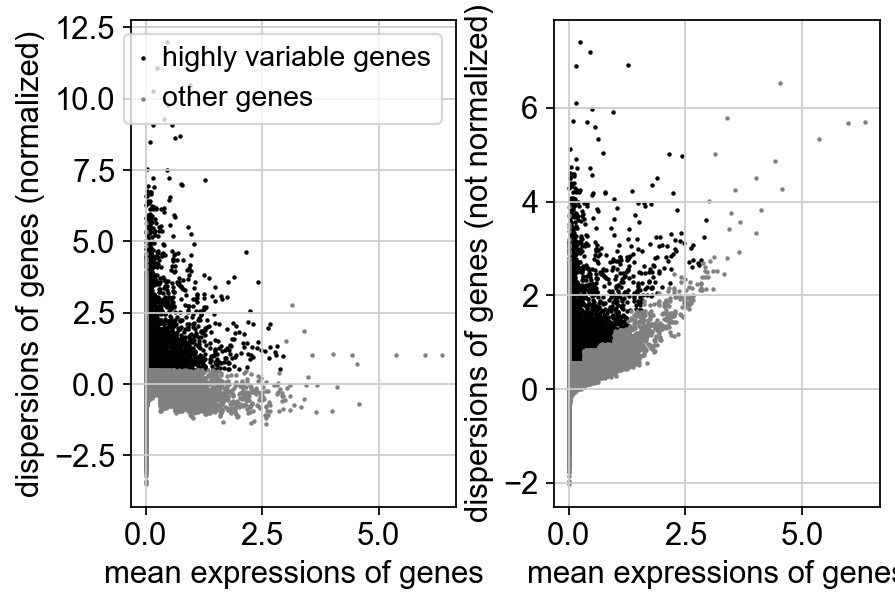

In [48]:
sc.pl.highly_variable_genes(adata)

In [49]:
#Ensure marker genes aren't making an impact to highly variable gene analysis downstream
adata.var.highly_variable['EGFP'] = False
adata.var.highly_variable['mScarlet'] = False
adata.var.highly_variable['Cre'] = False
adata.var.highly_variable['ERT'] = False
adata.var.highly_variable['iDTR'] = False
adata.var.highly_variable['tdTomato'] = False
adata.var.highly_variable['mKate2'] = False
adata.var.highly_variable['Akaluc'] = False
adata.var.highly_variable['GLuc'] = False
adata.var.highly_variable['CLuc'] = False
adata.var.highly_variable['tagBFP'] = False

/var/folders/xc/wjwqs2j55dqgp2ghrn6nmlj1nlk7kz/T/ipykernel_38020/850513103.py:2: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  adata.var.highly_variable['EGFP'] = False
/var/folders/xc/wjwqs2j55dqgp2ghrn6nmlj1nlk7kz/T/ipykernel_38020/8505131

In [50]:
adata.raw = adata

In [51]:
adata.write('write/allmice-IGO16235.h5ad', compression='gzip')

In [52]:
sc.pp.scale(adata, max_value=10)

/Users/chanj2/opt/miniconda3/envs/part1-cellrank/lib/python3.11/functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


## Principal component analysis

In [53]:
sc.tl.pca(adata, svd_solver='arpack', n_comps=150)

computing PCA
    with n_comps=150
    finished (0:00:06)


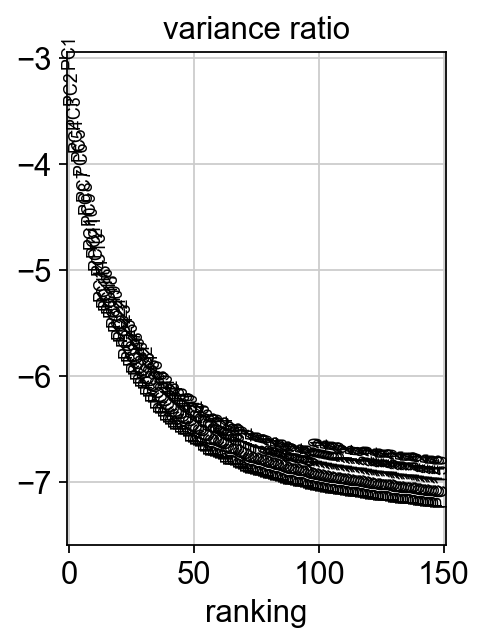

In [54]:
sc.pl.pca_variance_ratio(adata, log=True, n_pcs=150)

In [55]:
adata.write(results_file, compression='gzip')

## Computing the neighborhood graph

In [56]:
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=80)

computing neighbors
    using 'X_pca' with n_pcs = 80
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:05)


## Embedding the neighborhood graph

In [57]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:09)


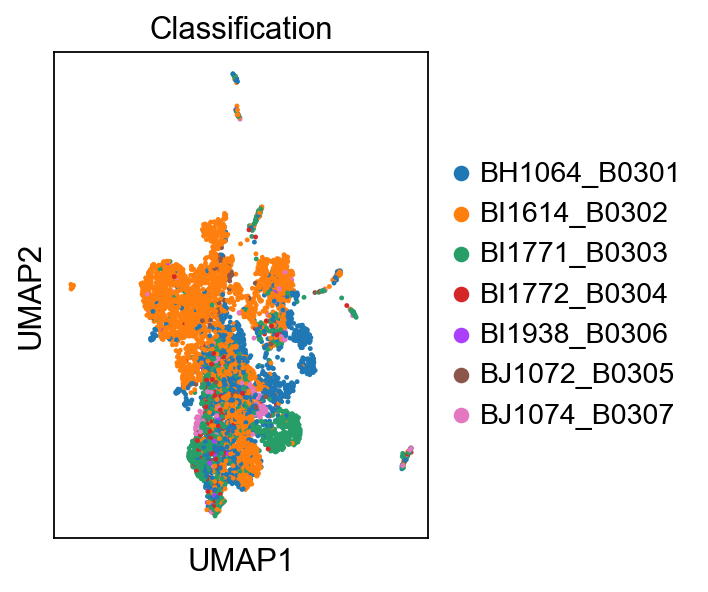

In [58]:
sc.pl.umap(adata, color=['Classification'])

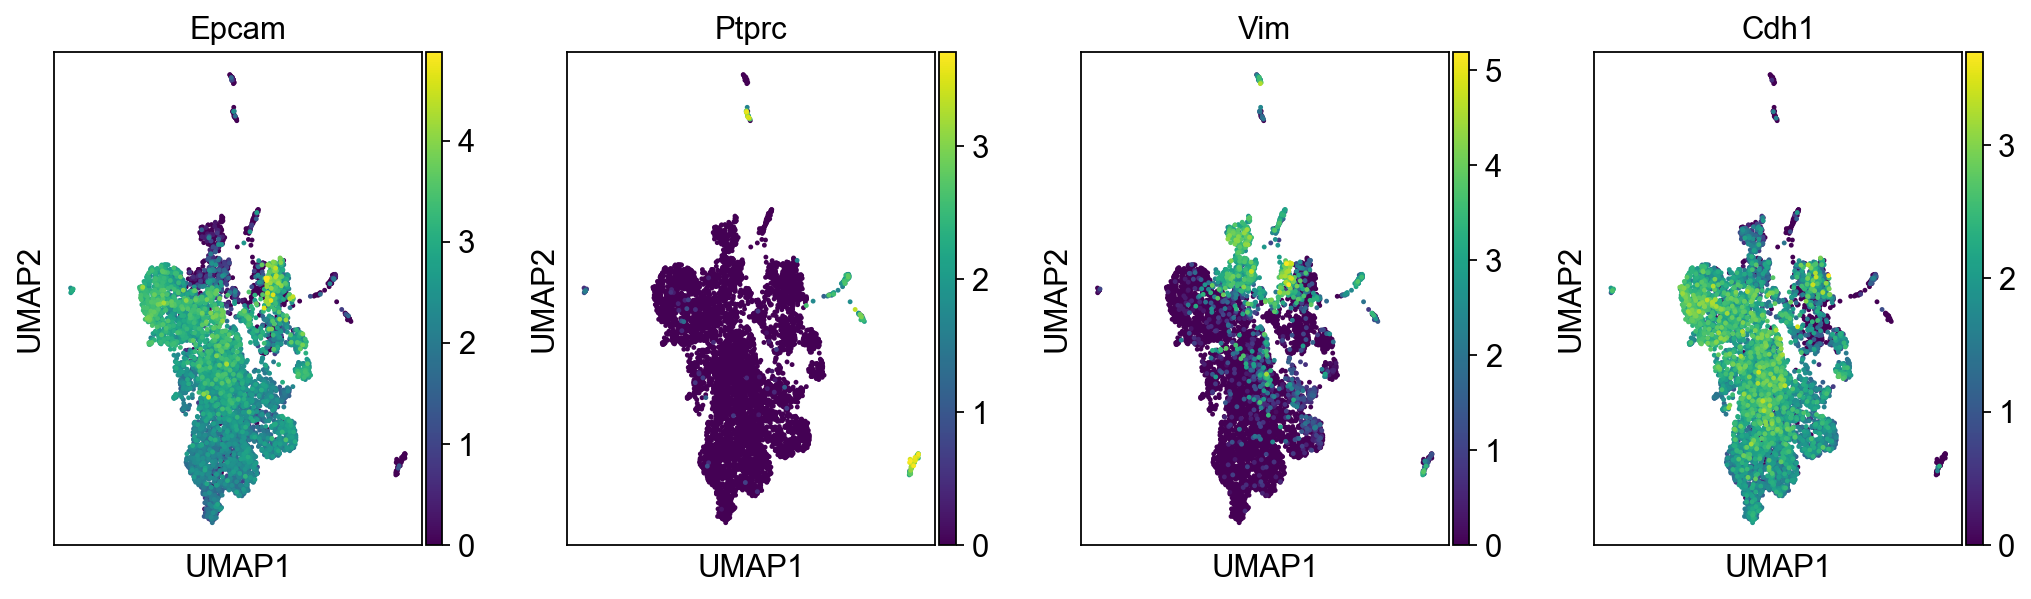

In [59]:
sc.pl.umap(adata, color=['Epcam','Ptprc','Vim', 'Cdh1',]) #'Ptprc','Cdh2'

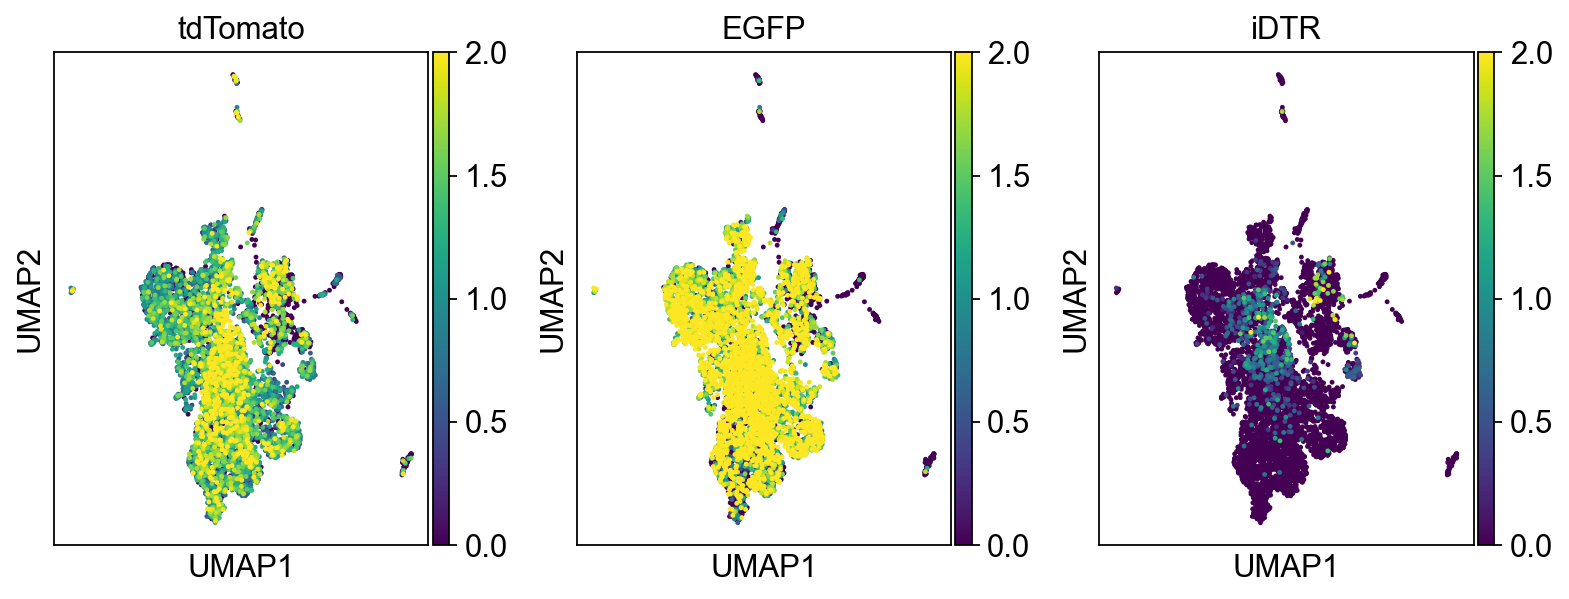

In [60]:
sc.pl.umap(adata, color=['tdTomato','EGFP','iDTR'], vmax=2) #,'mScarlet'

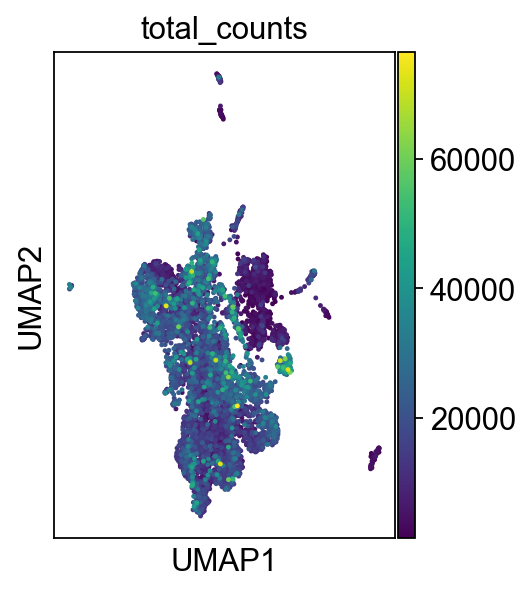

In [61]:
sc.pl.umap(adata, color=['total_counts'])

## Define scoring Functions

In [62]:
# Score Cluster 5 cells
import csv
clusters = {}
clusterkeys = []
HPCS = False

def resetClusters(hpcs = 'cell2020'):
    clusters = {}
    clusterkeys = []
    HPCS = False
    try:
        if hpcs == 'cell2020':         
            with open('../../common_files/clusters_cell2020.csv',encoding='utf-8-sig') as csvfile:
                csvreader = csv.reader(csvfile, delimiter=",")
                for row in csvreader:
                    clusters[row[0]] = [x for x in row[1:] if x != '']
            for i in range(1,13):
                #if i == 9: continue
                clusterkeys.append('Cluster %i' % i)
            HPCS = 'Cluster 5'
        else:
            raise ValueError
    except ValueError:
        print("%s is an invalid choice" % hpcs)
        raise
    return (clusters, clusterkeys, HPCS)

(clusters, clusterkeys, HPCS) = resetClusters('cell2020')

In [63]:
def scoreAndPlot(ad, excludeList = None, groupby="Classification",rotation=90,numgenes=500,ctlgenes=25):
    #cmap = 'Reds' #colormap
    cmap = 'jet' #colormap
    if excludeList == None:
        for i in clusterkeys:
            if (numgenes > ctlgenes):
                ctlgenes = numgenes
            sc.tl.score_genes(ad, clusters[i][0:numgenes],score_name="%s" % i, ctrl_size=ctlgenes)  
  
        sc.pl.umap(ad, color=clusterkeys, color_map=cmap)
        sc.pl.dotplot(ad, clusterkeys, groupby=groupby, swap_axes=True)

In [64]:
from scipy.stats import ranksums

def HPCSViolinPlot(ad, cluster='0', groupby='leiden', score='Cluster5', save=None, singleGene=False):
    ad.obs['Cl5'] = 'not HPCS'
    ad.obs.loc[ad.obs[groupby].isin([cluster]), 'Cl5'] = 'HPCS'

    if singleGene:
        pvalue = ranksums(ad[ad.obs['Cl5'].isin(['HPCS'])][:,score].X.toarray(),ad[~ad.obs['Cl5'].isin(['HPCS'])][:,score].X.toarray())[1]
    else:
        pvalue = ranksums(ad[ad.obs['Cl5'].isin(['HPCS'])].obs[score],ad[ad.obs['Cl5'].isin(['not HPCS'])].obs[score])[1]
    sc.pl.violin(ad, score, groupby='Cl5', xlabel = 'p = ' + str(pvalue), save=save)

computing score 'Cluster 1'
    finished: added
    'Cluster 1', score of gene set (adata.obs).
    1489 total control genes are used. (0:00:00)
computing score 'Cluster 2'
    finished: added
    'Cluster 2', score of gene set (adata.obs).
    1495 total control genes are used. (0:00:00)
computing score 'Cluster 3'
    finished: added
    'Cluster 3', score of gene set (adata.obs).
    1392 total control genes are used. (0:00:00)
computing score 'Cluster 4'
    finished: added
    'Cluster 4', score of gene set (adata.obs).
    1697 total control genes are used. (0:00:00)
computing score 'Cluster 5'
    finished: added
    'Cluster 5', score of gene set (adata.obs).
    1590 total control genes are used. (0:00:00)
computing score 'Cluster 6'
    finished: added
    'Cluster 6', score of gene set (adata.obs).
    2090 total control genes are used. (0:00:00)
computing score 'Cluster 7'
    finished: added
    'Cluster 7', score of gene set (adata.obs).
    1393 total control genes are u

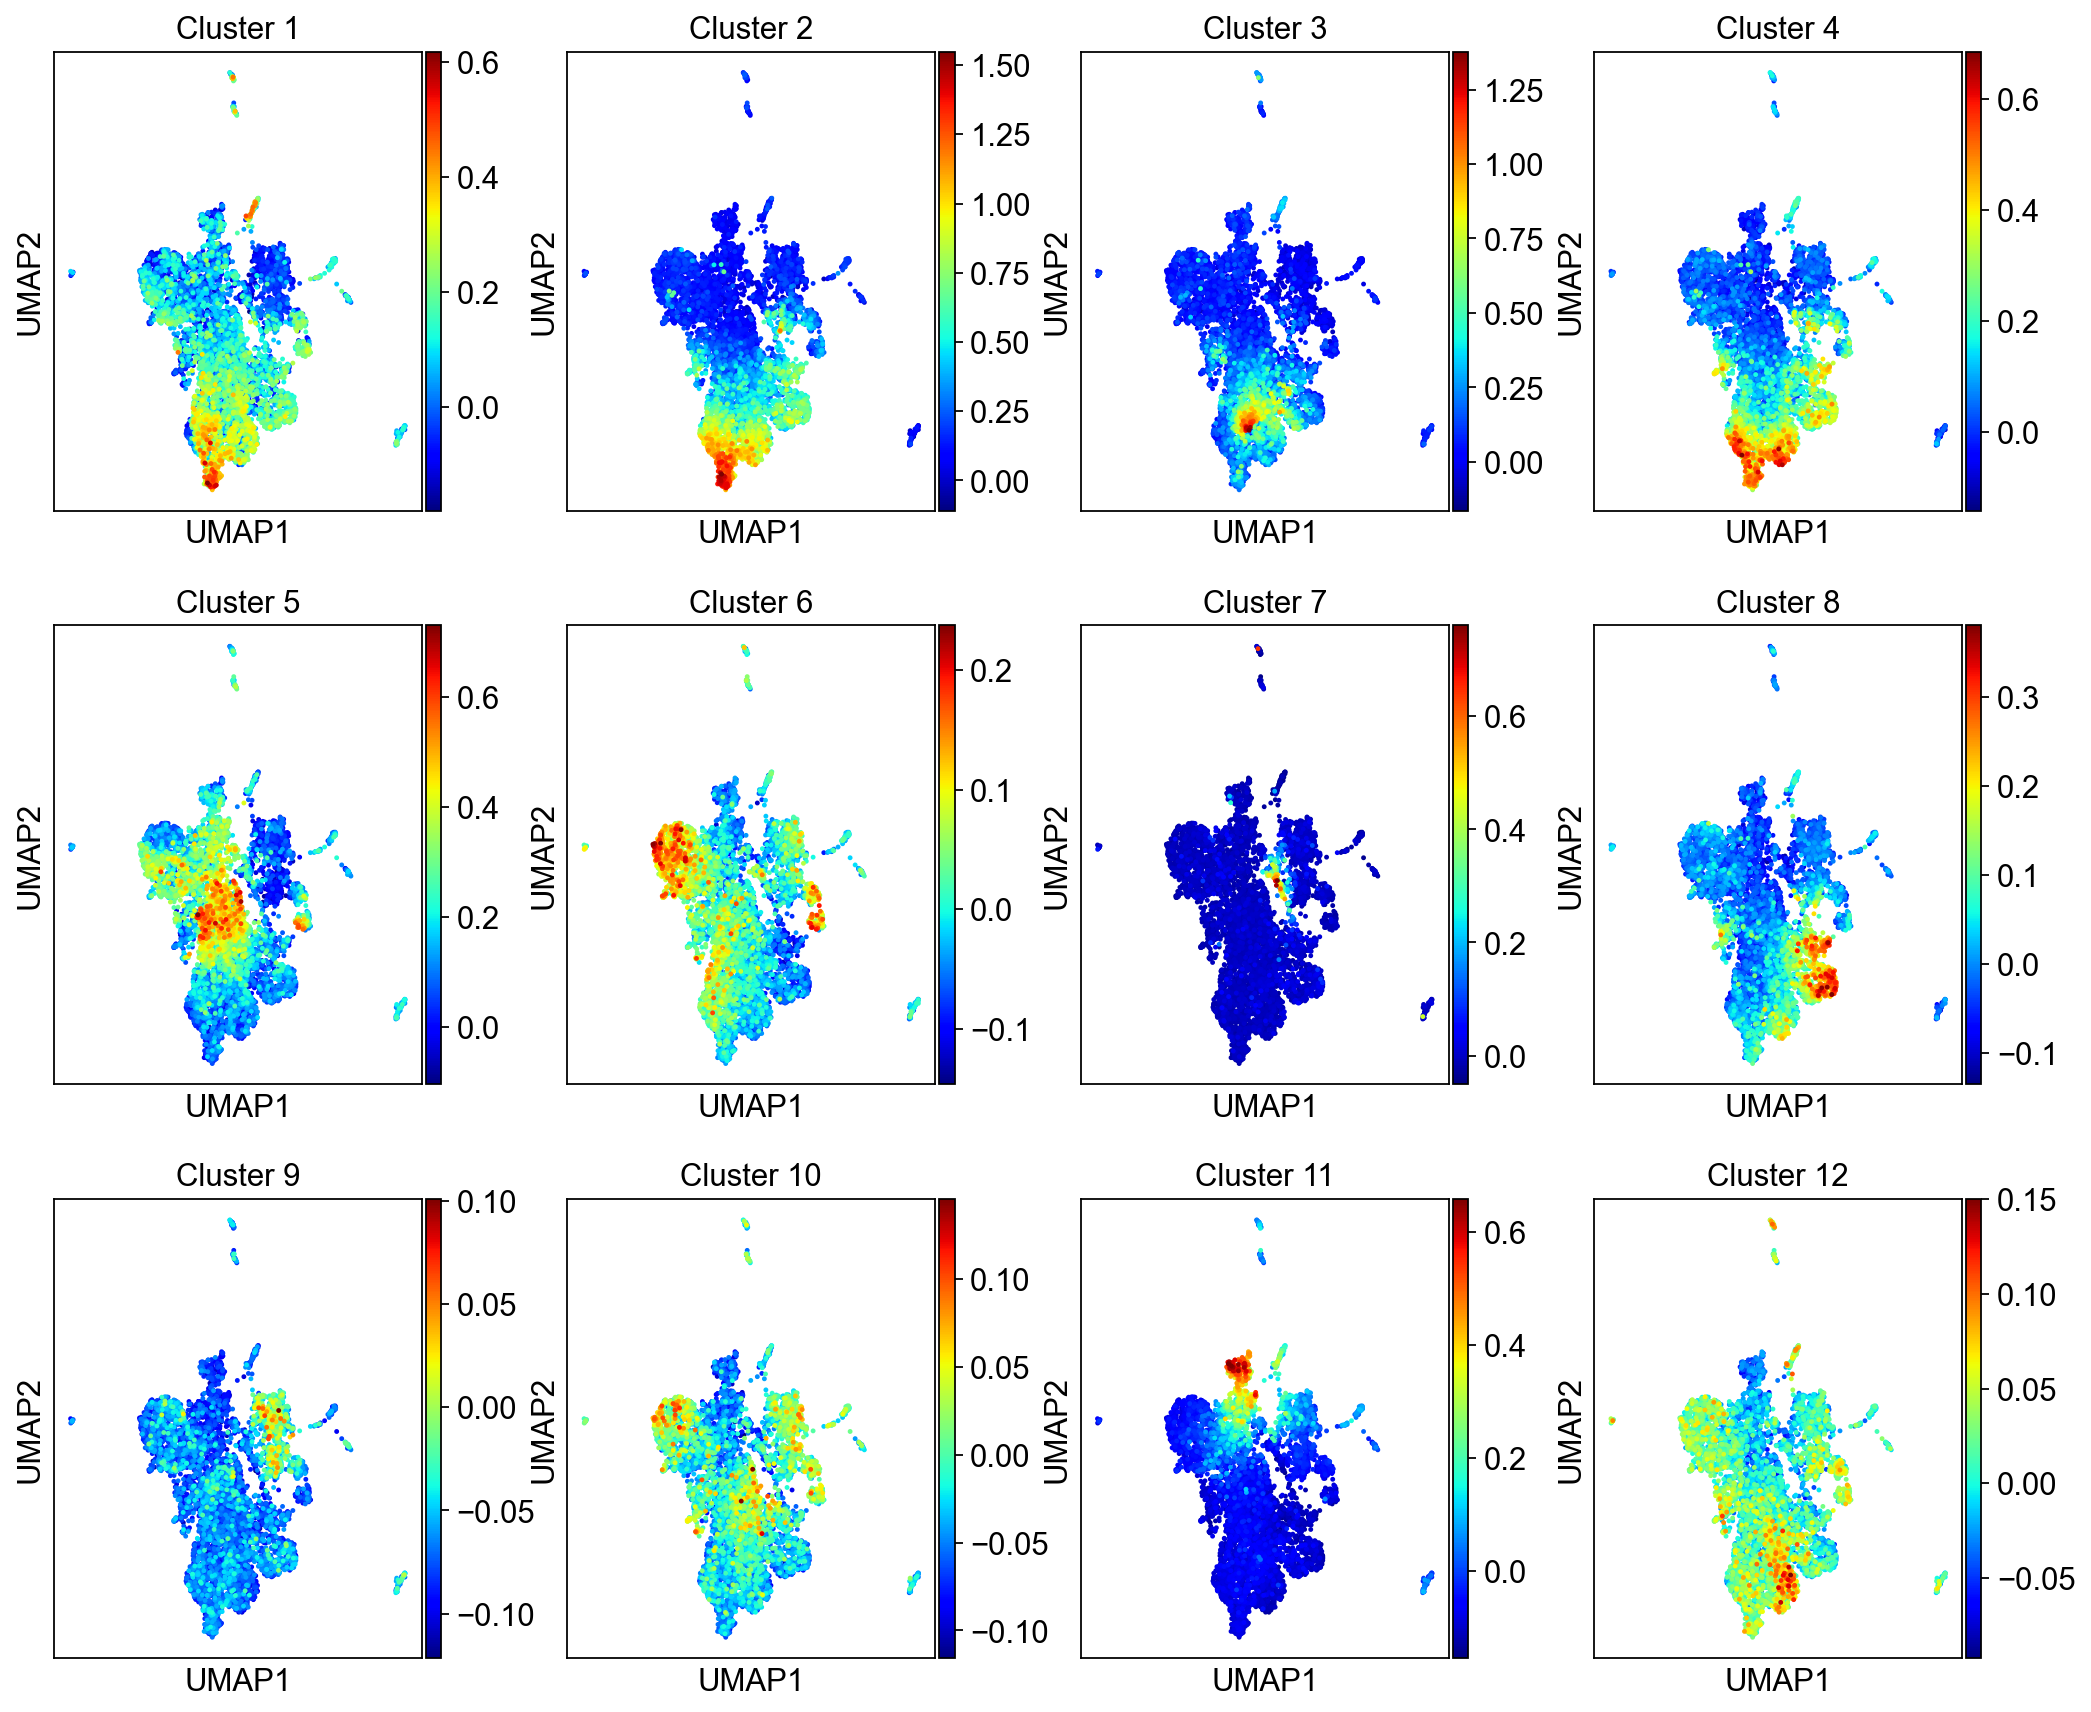

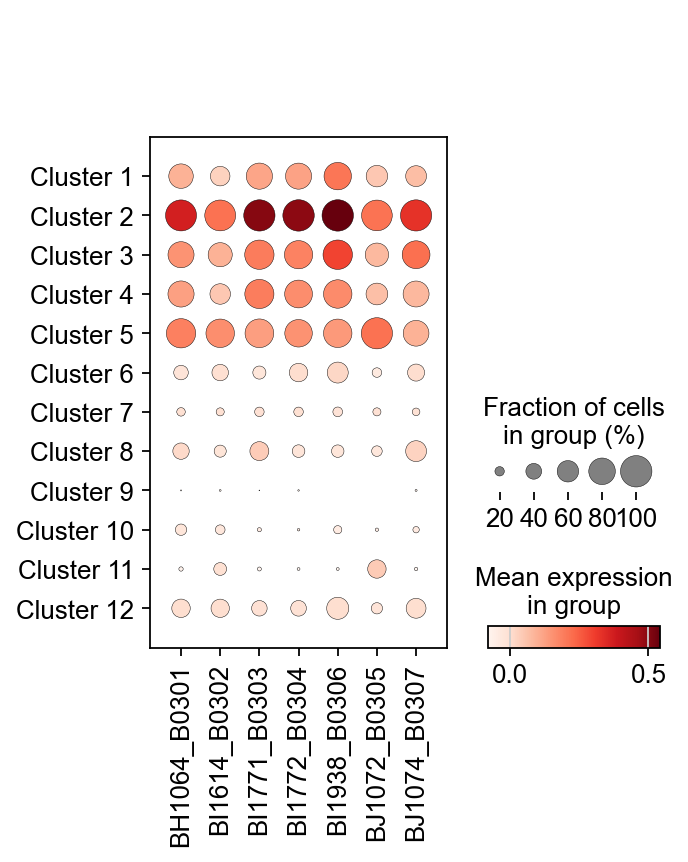

In [65]:
scoreAndPlot(adata, numgenes=100)

## Clustering the neighborhood graph

In [66]:
sc.tl.leiden(adata, resolution=0.2)
#sc.tl.leiden(adata, resolution=0.25)

running Leiden clustering


/var/folders/xc/wjwqs2j55dqgp2ghrn6nmlj1nlk7kz/T/ipykernel_38020/524787540.py:1: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution=0.2)


    finished: found 11 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


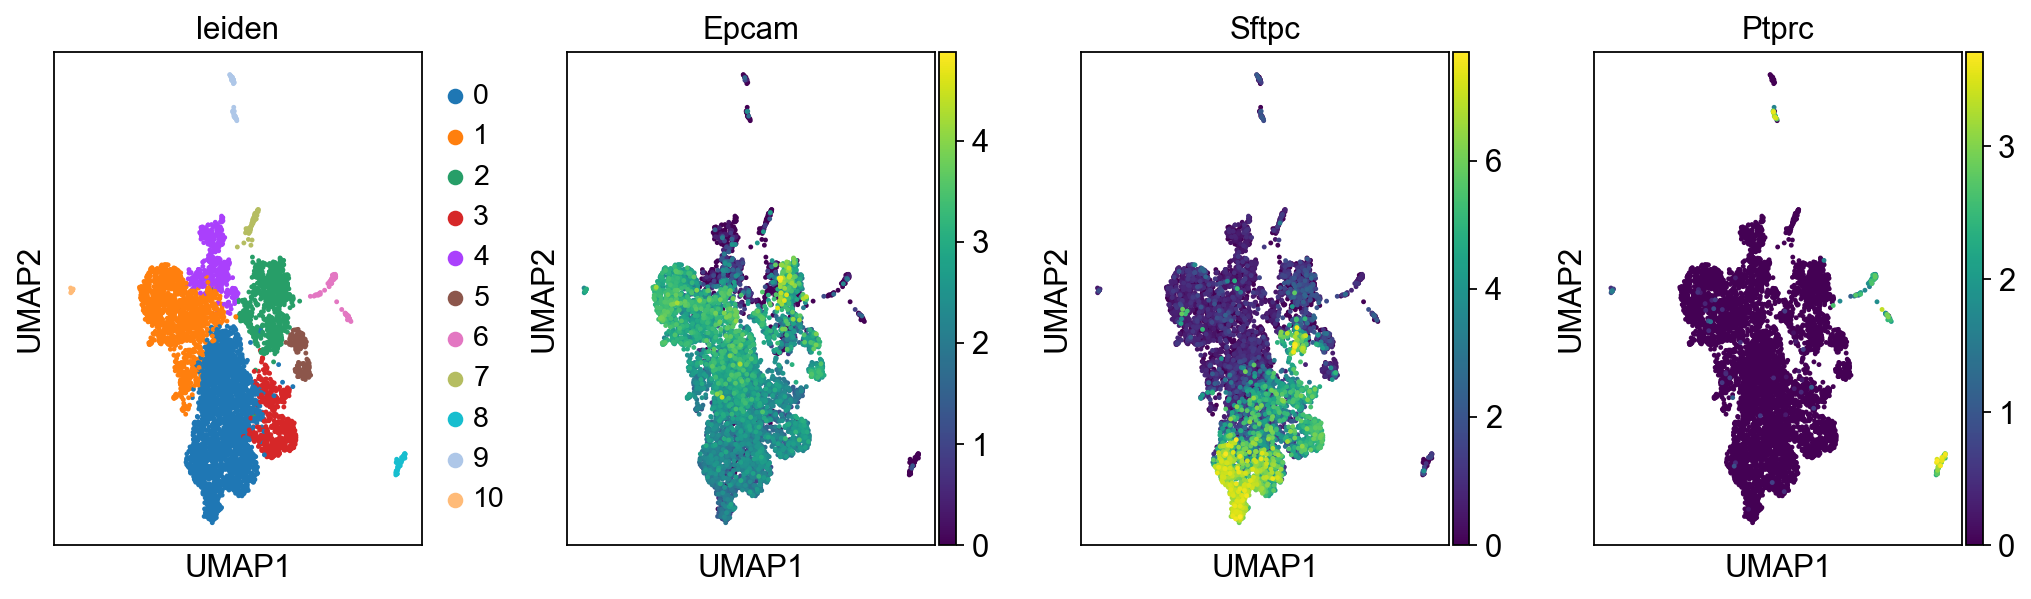

(None,)

In [67]:
sc.pl.umap(adata, color=['leiden', 'Epcam', 'Sftpc', # Tumor cells
                         'Ptprc']), #immune
                         #  'Cd4', 'Cd8a', #T cell #'Cd3e',
                         # 'Cd19', 'Ms4a1', 'Cd22', # B cell
                         # #'Itgax', 'Il3ra', # Dendritic Cell
                         # 'Ncam1',# 'Ncr1', # NK Cell
                         # 'Cd34', # Hematopoetic stem cell
                         # #'Cd14', 'Cd33', # macrophage
                         # #'Ceacam8' # Granulocyte
                         # 'Itga2b', 'Itgb3', 'Selp', #platelet
                         # #'Gypa',  # erythrocyte
                         # #'Mcam', 'Vcam1', 'Pecam1', 'Sele', # endothelial cell
                         # 'Cd109', 'Wnt5a', 'Kras'])

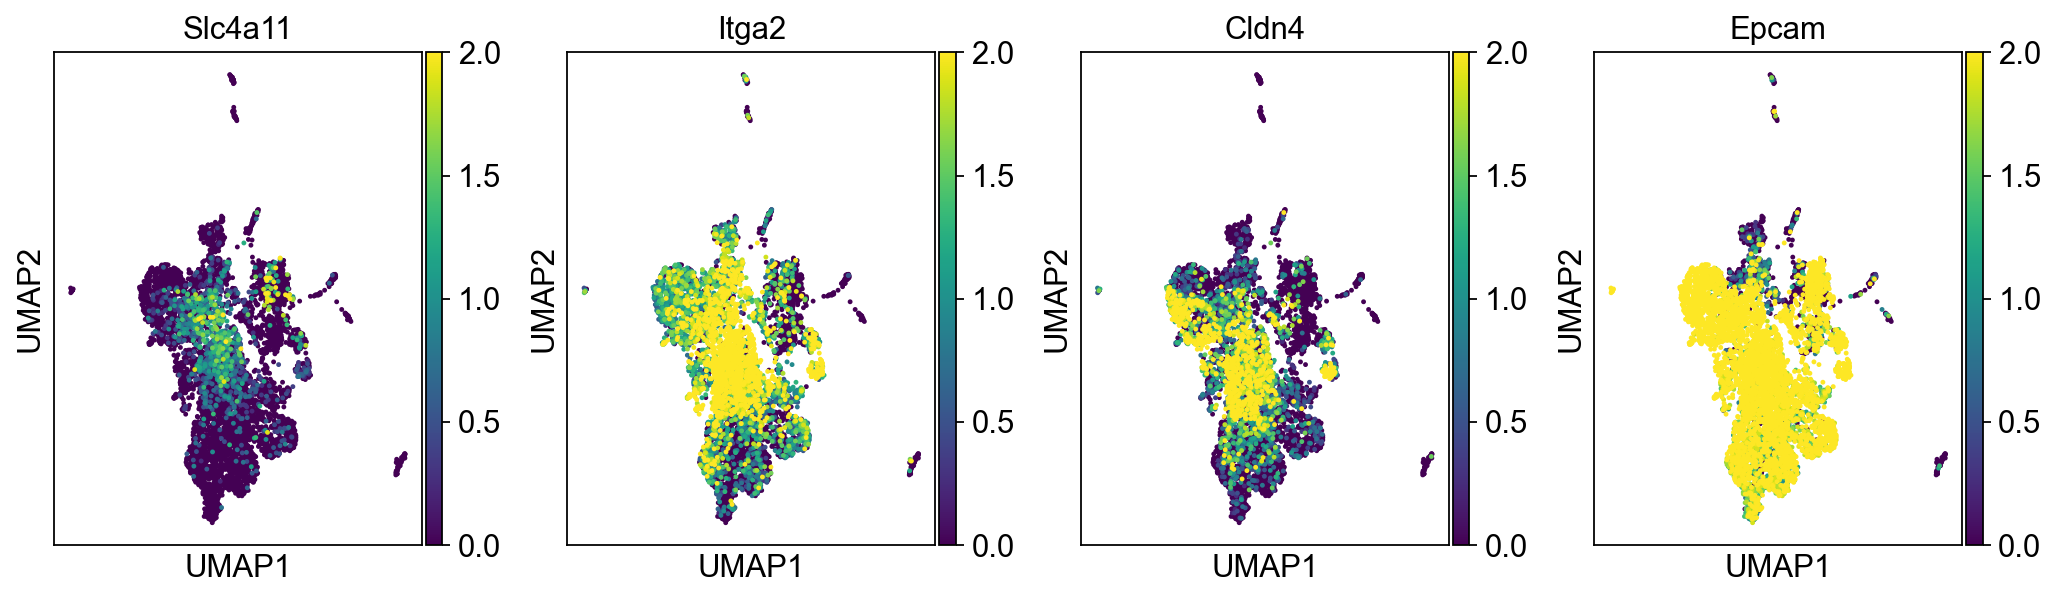

In [68]:
sc.pl.umap(adata, color=['Slc4a11', 'Itga2', 'Cldn4','Epcam'], vmax=2) #'Tigit', 

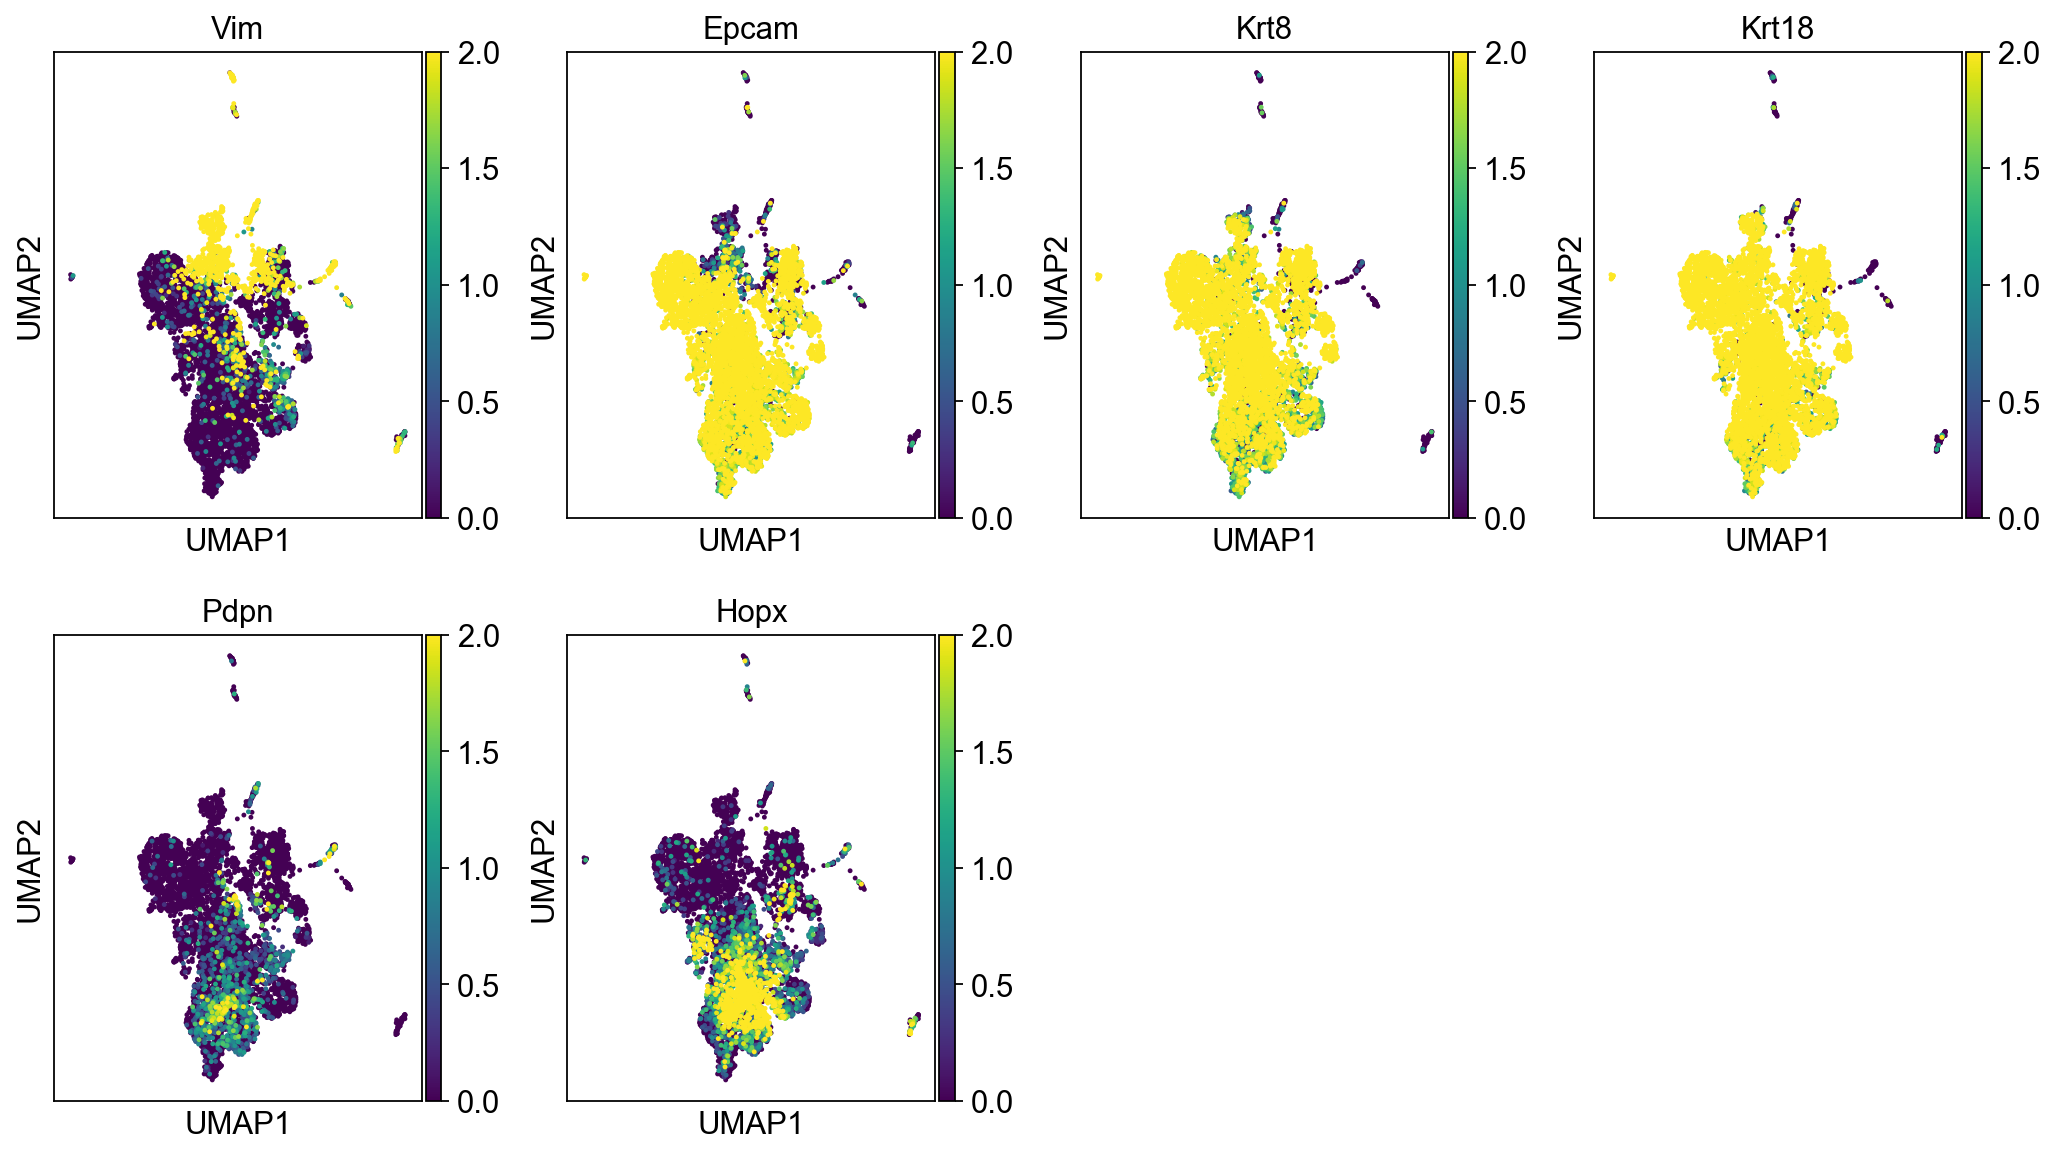

In [69]:
sc.pl.umap(adata, color=['Vim', 'Epcam', 'Krt8', 'Krt18', 'Pdpn', 'Hopx'], vmax=2) #'Pecam1',

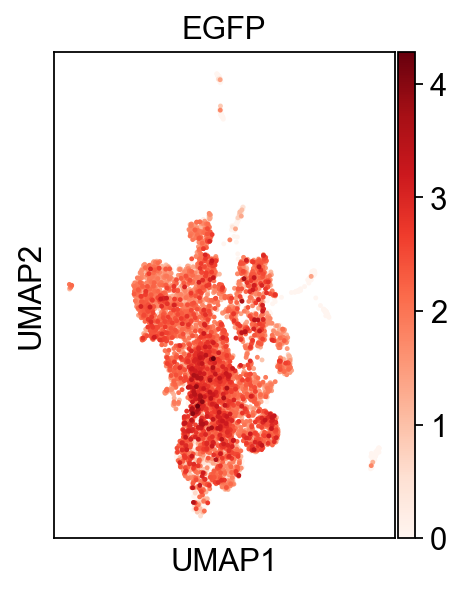

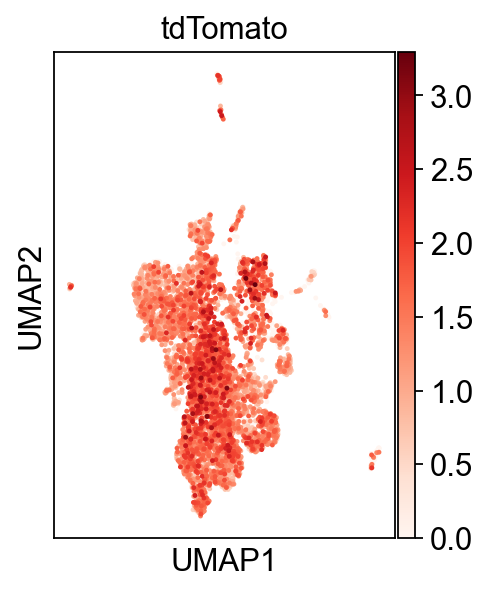

In [70]:
sc.pl.umap(adata, color=['EGFP'], cmap='Reds')
sc.pl.umap(adata, color=['tdTomato'], cmap='Reds')

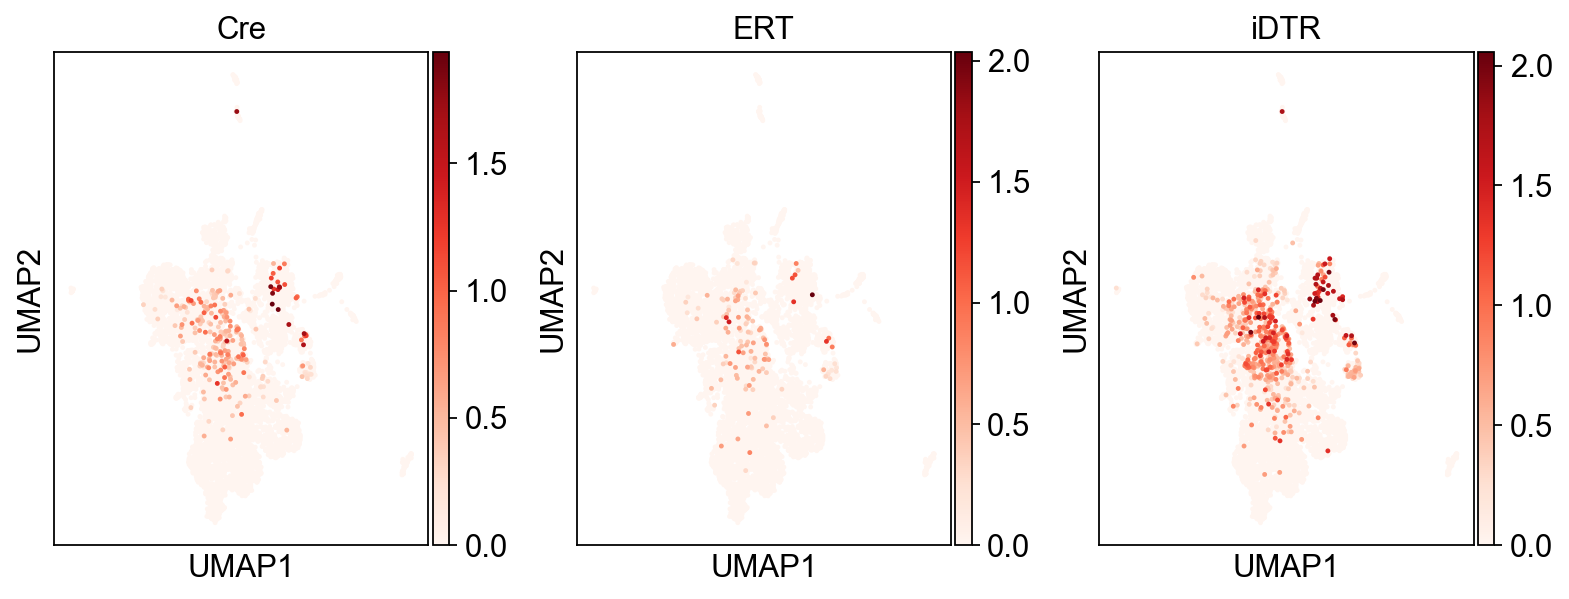

In [71]:
sc.pl.umap(adata, color=["Cre", "ERT",'iDTR'], cmap='Reds') #"mScarlet", 

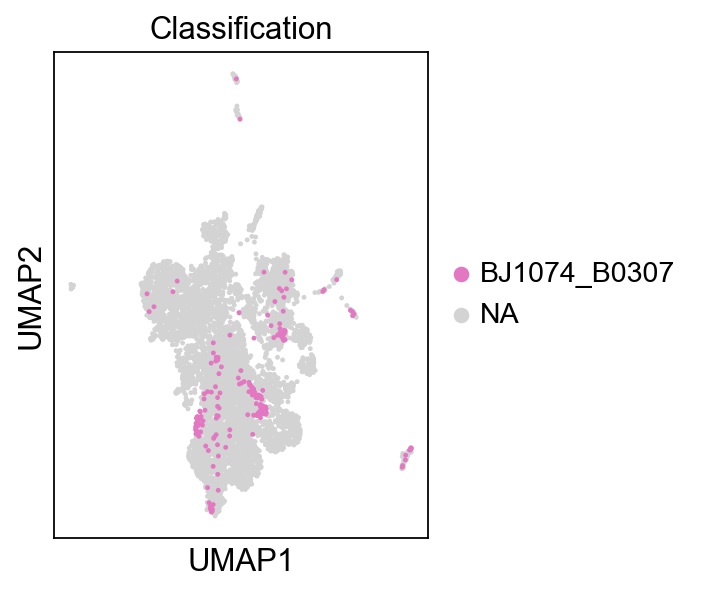

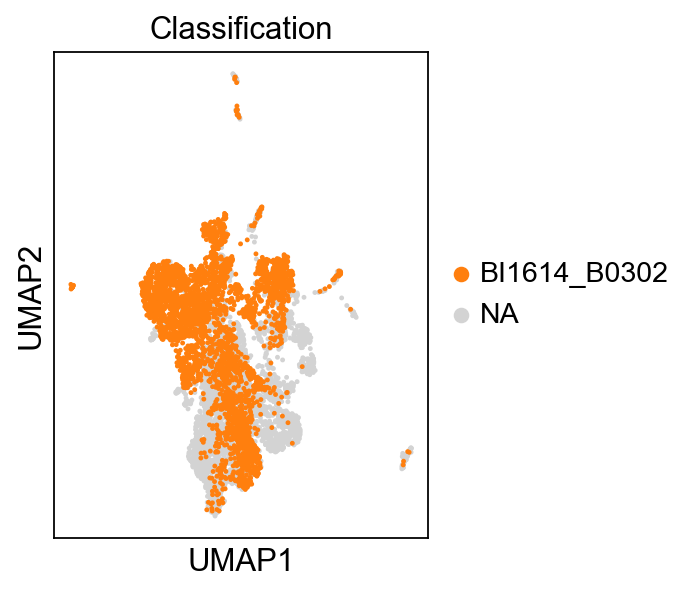

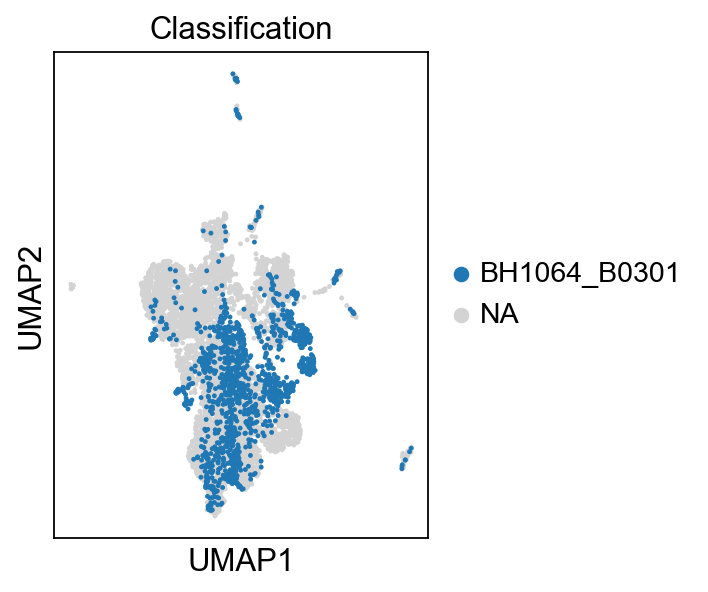

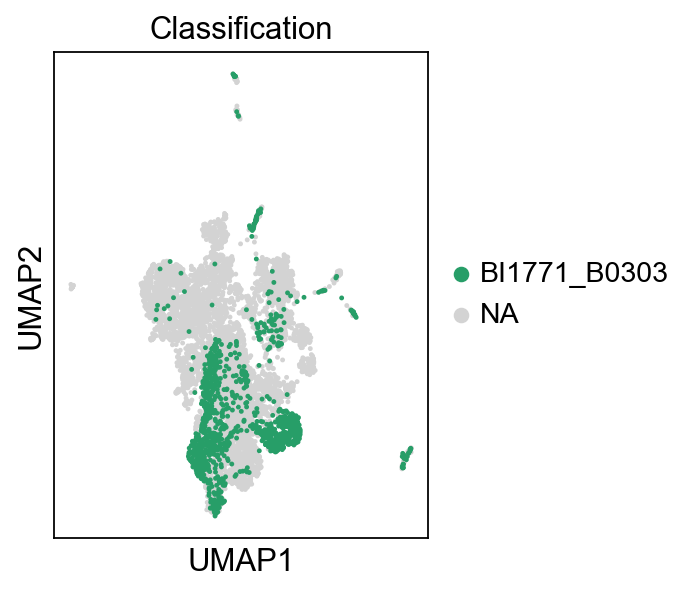

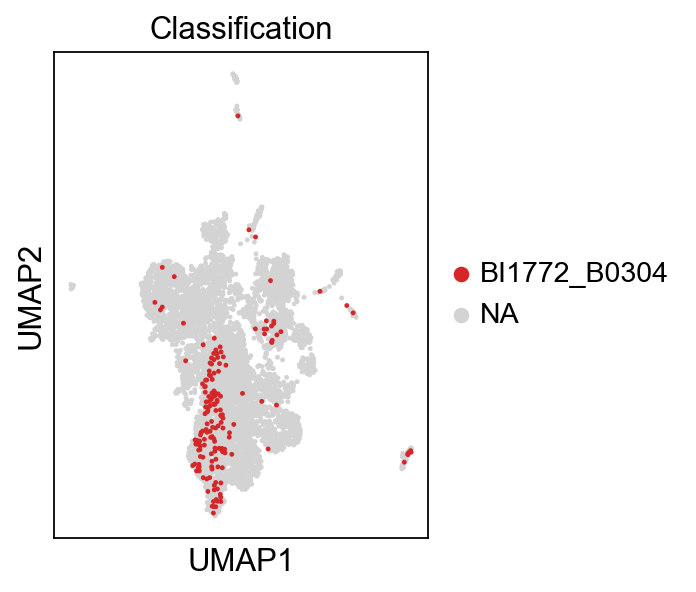

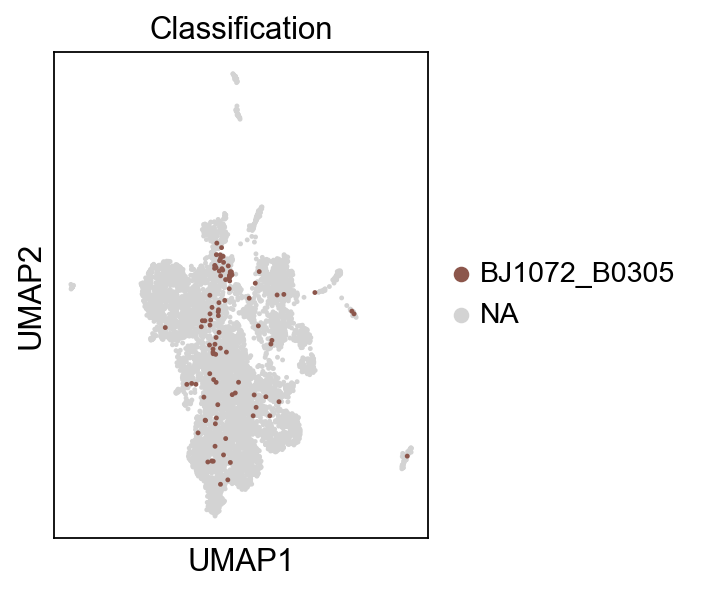

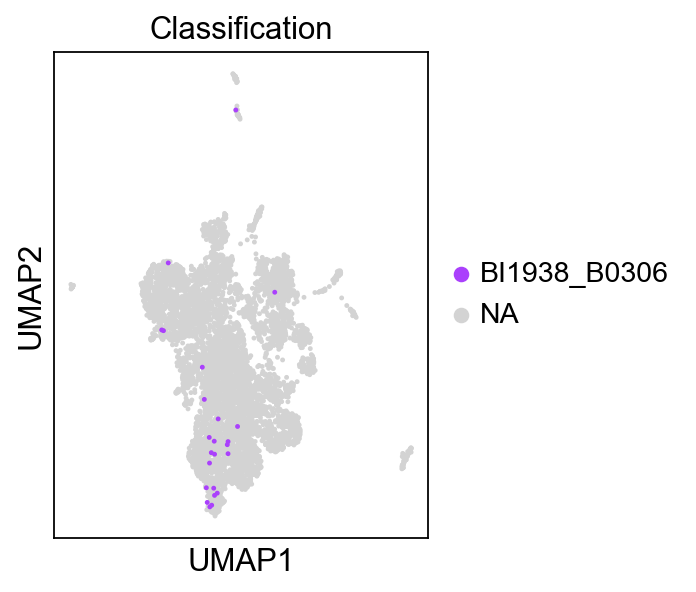

In [72]:
for label in adata.obs['Classification'].unique():
    sc.pl.umap(adata, color='Classification',groups=[label])

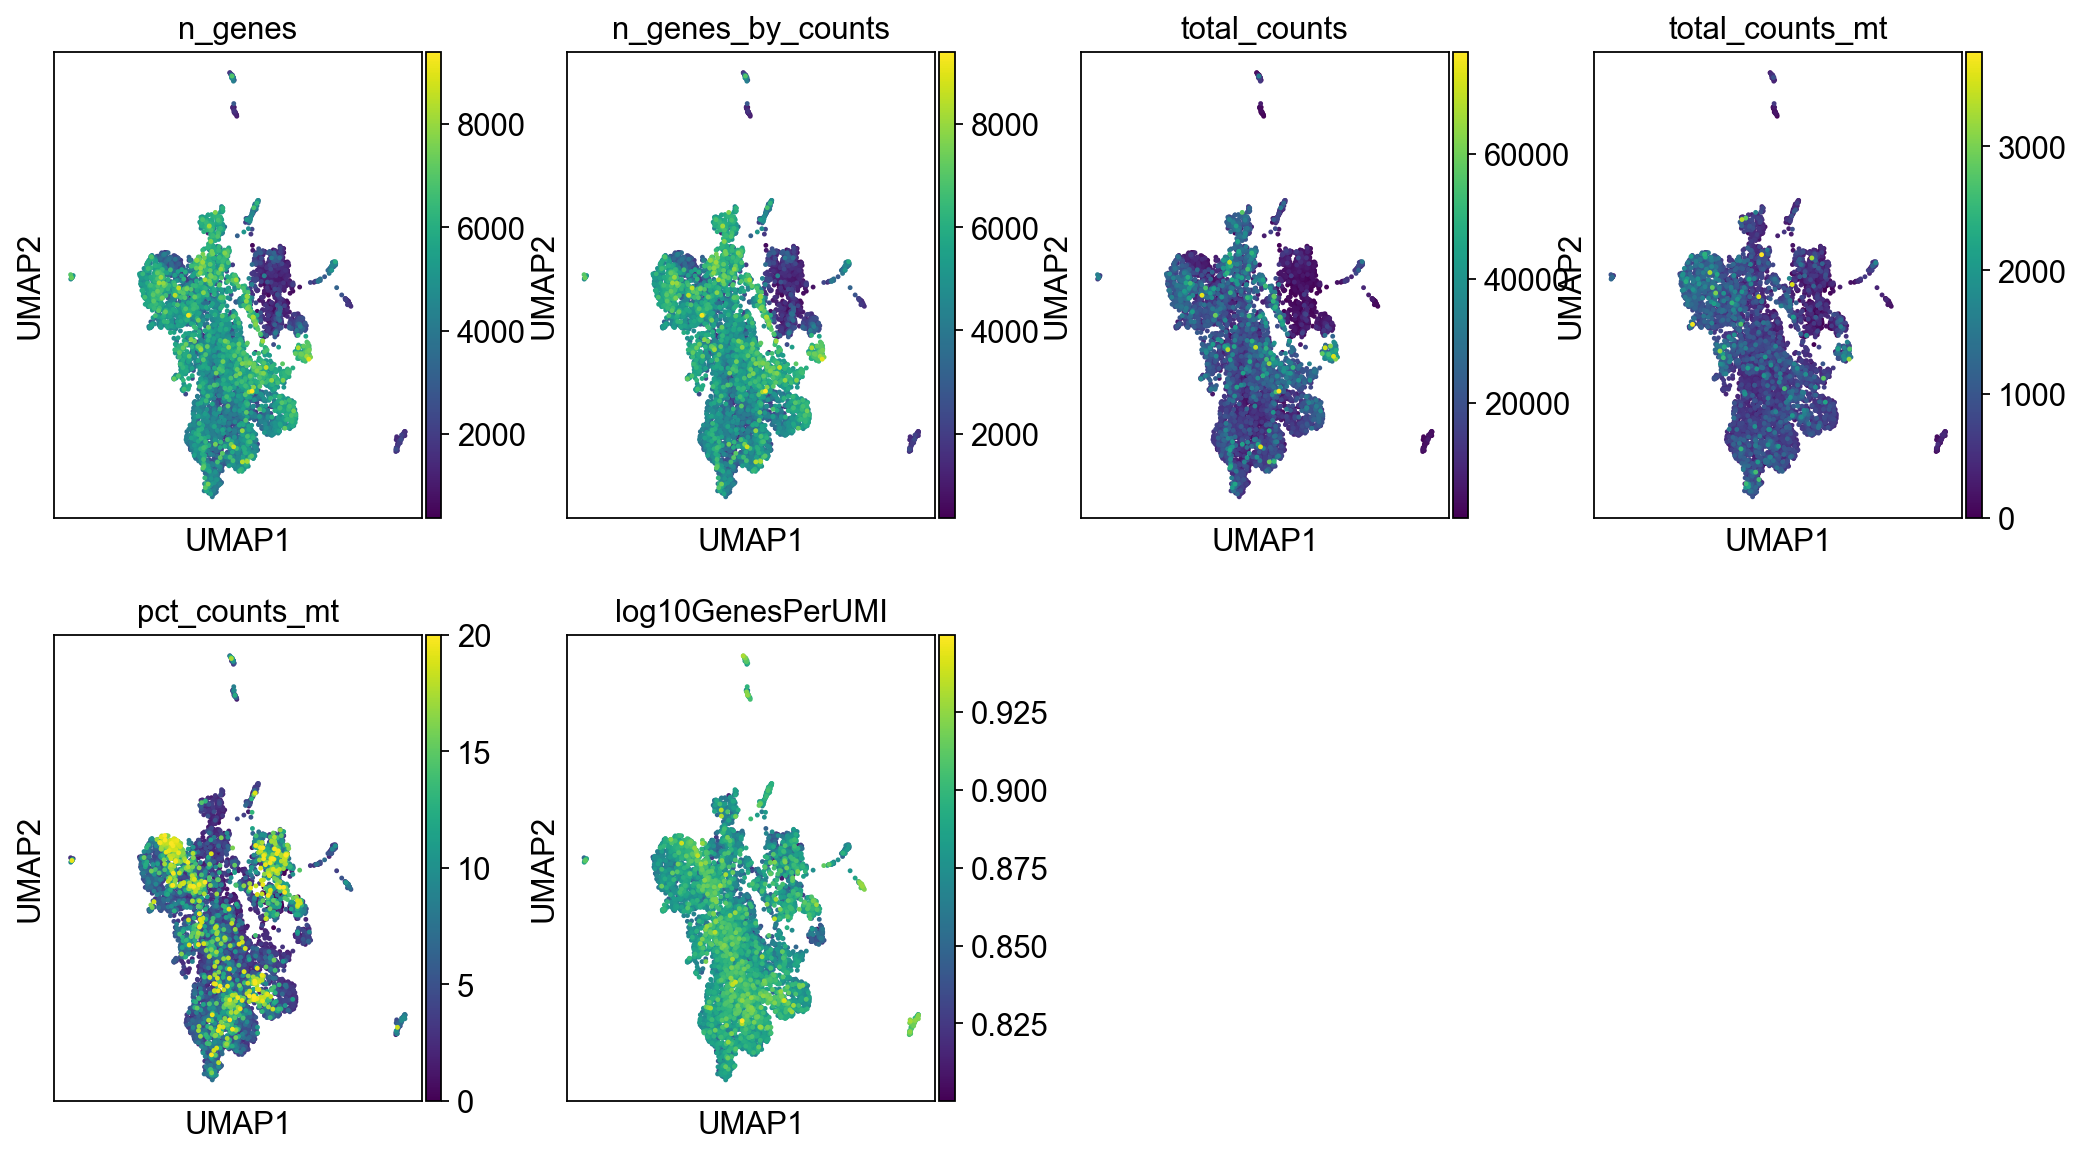

In [73]:
sc.pl.umap(adata,color=['n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt',
       'pct_counts_mt', 'log10GenesPerUMI'])

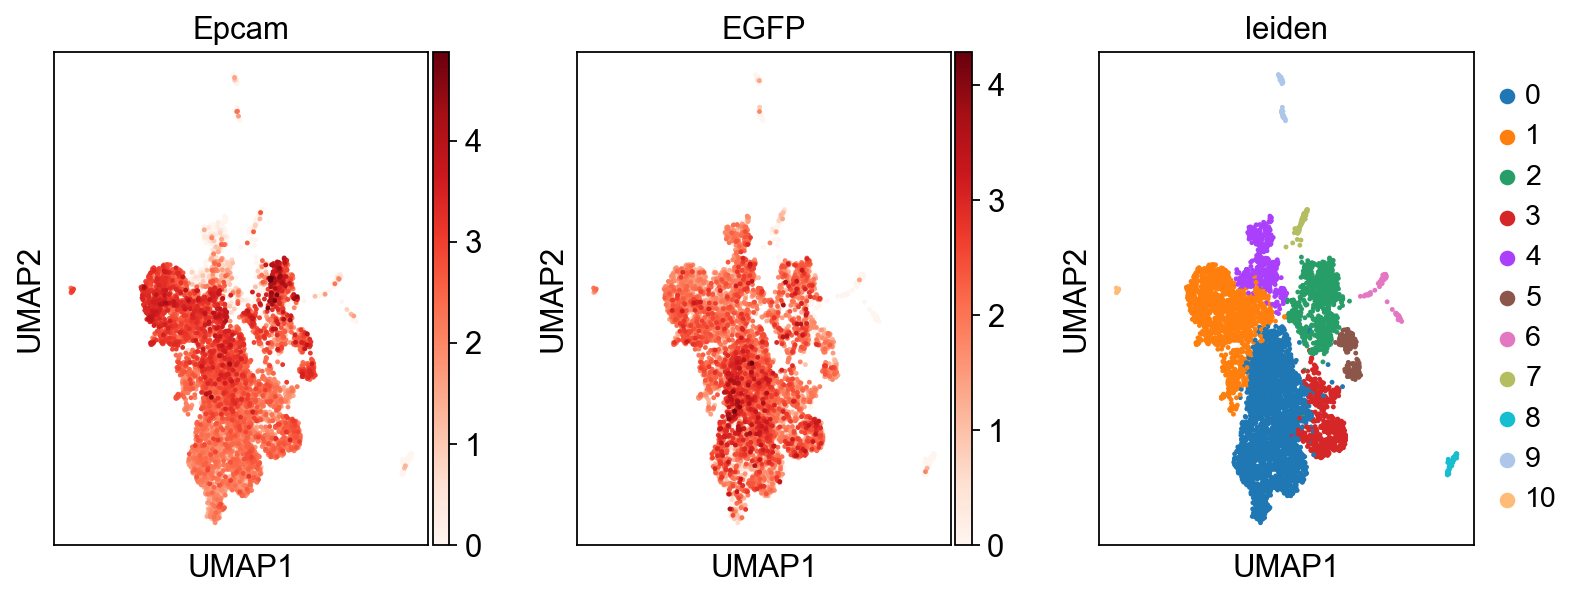

In [74]:
sc.pl.umap(adata, color=['Epcam','EGFP','leiden'],cmap="Reds")

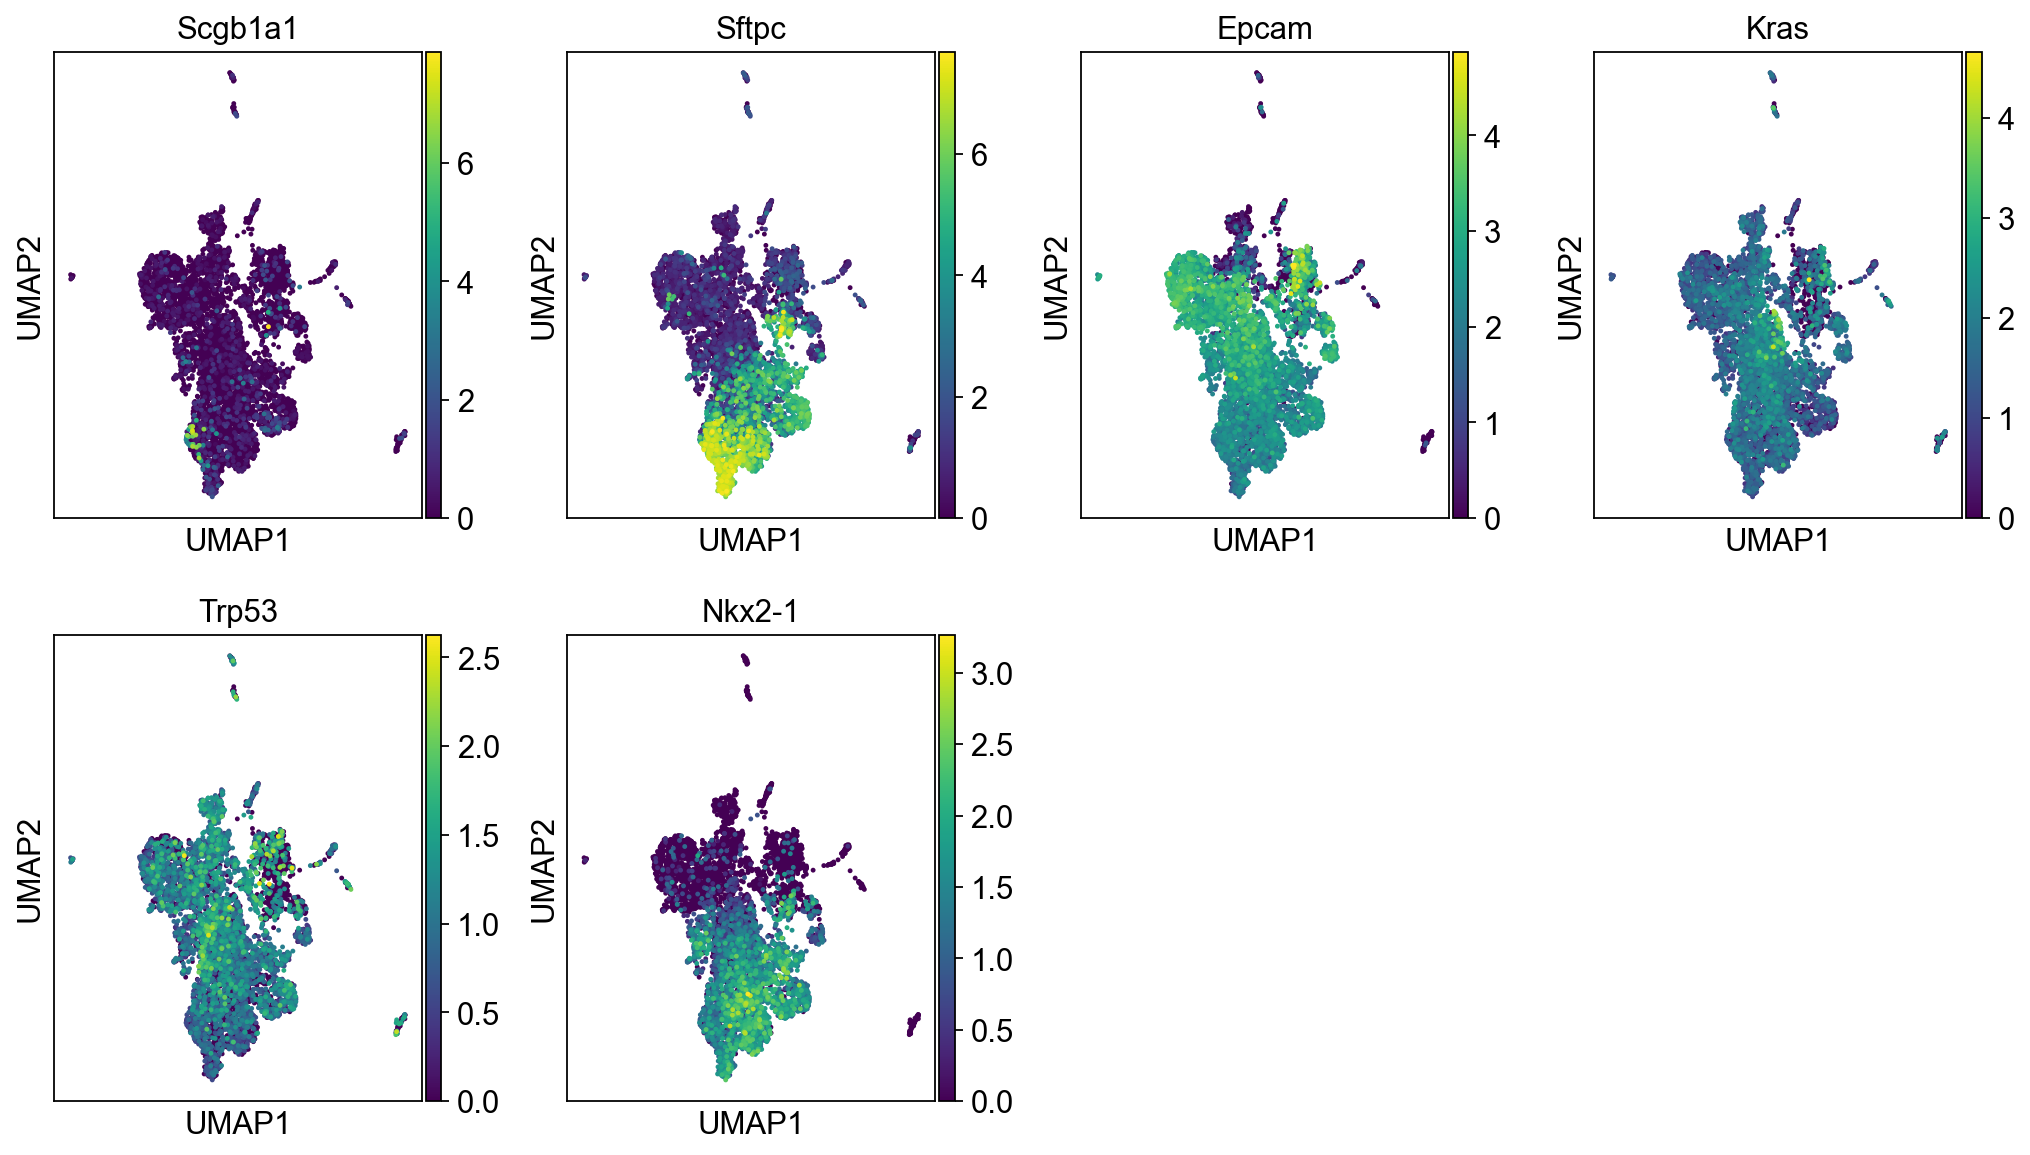

In [75]:
sc.pl.umap(adata, color=['Scgb1a1','Sftpc','Epcam','Kras', 'Trp53','Nkx2-1'])

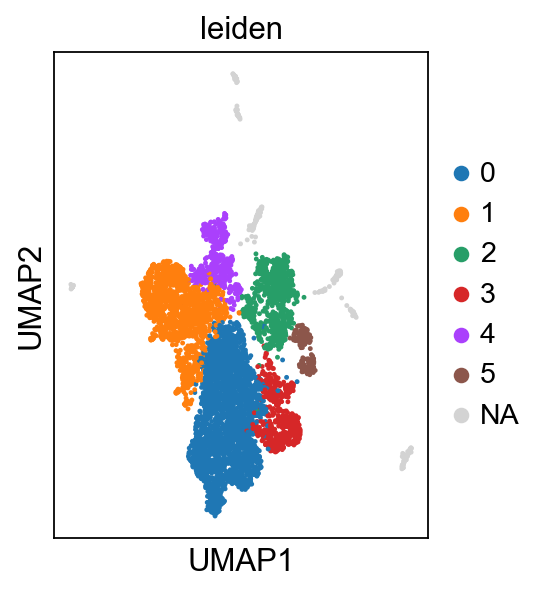

In [76]:
sc.pl.umap(adata, color=['leiden'], groups=['0','1','2','3','4','5'])

## Select Tumor Cells

In [77]:
# Select only those subset of cells that are useful
adata2 = sc.read('write/allmice-IGO16235.h5ad')
adata = adata2[adata.obs['leiden'].isin(['0','1','2','3','4','5']),:] # keep tumor cells
del adata2

In [78]:
#fix a bug; 'base' is None but that doesn't seem to have transferred
adata.uns['log1p'] = {}
adata.uns['log1p']['base'] = None

/var/folders/xc/wjwqs2j55dqgp2ghrn6nmlj1nlk7kz/T/ipykernel_38020/2000007.py:2: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns['log1p'] = {}


In [79]:
sc.pp.highly_variable_genes(adata)#, batch_key='Classification')

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [80]:
#Ensure marker genes aren't making an impact to highly variable gene analysis downstream
adata.var.highly_variable['EGFP'] = False
adata.var.highly_variable['mScarlet'] = False
adata.var.highly_variable['Cre'] = False
adata.var.highly_variable['ERT'] = False
adata.var.highly_variable['iDTR'] = False
adata.var.highly_variable['tdTomato'] = False
adata.var.highly_variable['mKate2'] = False
adata.var.highly_variable['Akaluc'] = False
adata.var.highly_variable['GLuc'] = False
adata.var.highly_variable['CLuc'] = False
adata.var.highly_variable['tagBFP'] = False

/var/folders/xc/wjwqs2j55dqgp2ghrn6nmlj1nlk7kz/T/ipykernel_38020/850513103.py:2: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  adata.var.highly_variable['EGFP'] = False
/var/folders/xc/wjwqs2j55dqgp2ghrn6nmlj1nlk7kz/T/ipykernel_38020/8505131

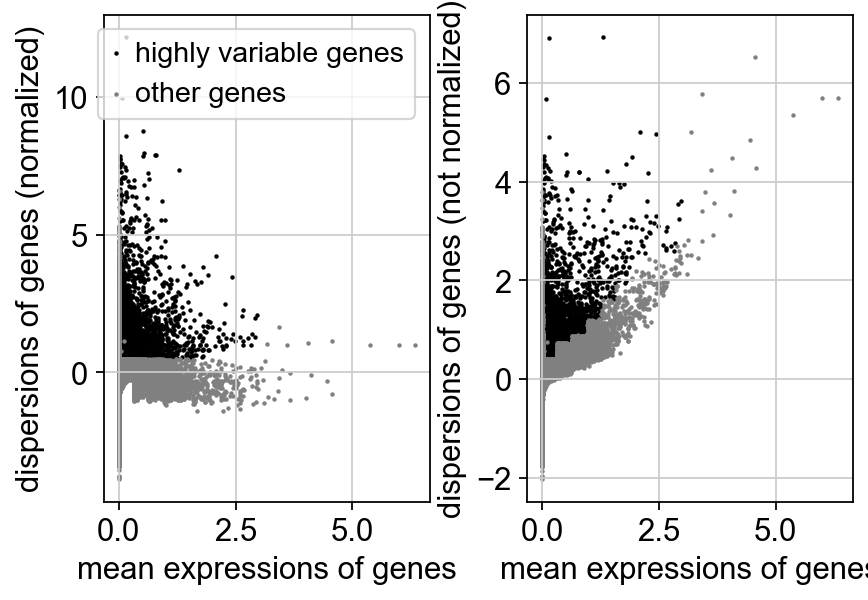

In [81]:
sc.pl.highly_variable_genes(adata)

In [82]:
adata.raw = adata

In [83]:
adata.write('write/allmice-tumor-IGO16235.h5ad', compression='gzip')
#adata = sc.read('write/allmice-tumor.h5ad')